# Modeling the Joint Distribution of Wind Speed and Direction  using Gaussain Mixture Models

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Models, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from import_file import *
from helpers.parallel_helper import *
load_libs()

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0.
plt.rcParams['axes.ymargin'] = 0.

## 1.2 Read Data

In [2]:
# file_path= "./data/NCDC/us/baltimore/dat.txt" # time too short
# file_path= './data/NCDC/uk/boscombe_down/dat.txt' # 4?
# file_path= './data/NCDC/uk/middle_wallop/dat.txt' # good
# file_path= './data/NCDC/uk/southhamption/dat.txt' # high 0
# file_path= './data/NCDC/uk/bournemouth/dat.txt' 4?
# file_path= './data/NCDC/uk/tiree/dat.txt'  # try 4
# file_path= "./data/NCDC/uk/bealach_na_ba/dat.txt" # 
# file_path= "./data/NCDC/uk/skye_lusa/dat.txt" # 
# file_path= "./data/NCDC/uk/south_uist_range/dat.txt" 
# file_path= './data/NCDC/uk/marham/dat.txt' 
# file_path= "./data/NCDC/uk/holbeach/dat.txt"
# file_path= "./data/NCDC/uk/weybourne/dat.txt"
# file_path= "./data/NCDC/uk/cambridge/dat.txt"
# file_path= "./data/NCDC/uk/wattisham/dat.txt"
# file_path= "./data/NCDC/uk/benbecula/dat.txt" # truncate (untruncate in m/s), 4?

# file_path= "./data/NCDC/southeast_asia/singapore_changi/dat.txt" # 4 or 5?
# file_path= "./data/NCDC/southeast_asia/sultan_ismail/dat.txt" # 
# file_path= "./data/NCDC/southeast_asia/paya_lebar/dat.txt" # 2010-2014 has problem
# file_path= "./data/NCDC/east_asia/cheongju_intl/dat.txt" # 2005-2009  may have problem, fit is good
# file_path= "./data/NCDC/east_asia/daegu_ab/dat.txt" # recent 5 year may have problem, but fit is generally good

# file_path= "./data/NCDC/europe/landsberg_lech/dat.txt" # very good, can try 4
# file_path= "./data/NCDC/europe/laupheim/dat.txt" # double peak, 4; very good
# file_path= "./data/NCDC/europe/vatry/dat.txt"  # double peak, initial speed (should be good with m/s)
# file_path= "./data/NCDC/europe/avord/dat.txt" # try 4, initial speed (should be good with m/s)
# file_path= './data/NCDC/europe/ciampino/dat.txt' # try 4, bandwidth?
# file_path= "./data/NCDC/europe/holzdorf/dat.txt"
# file_path= "./data/NCDC/europe/neuburg/dat.txt"
# file_path= "./data/NCDC/europe/valladolid/dat.txt"
# file_path= "./data/NCDC/europe/barayas/dat.txt" # 
# file_path= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer, 4?
# file_path= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer with less data, use m/s
# file_path= './data/NCDC/europe/tenerife_sur/dat.txt'  # some directions are blocked

# file_path= "./data/NCDC/oceania/narrandera/dat.txt" # high 0
# file_path= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" # high 0
# file_path= "./data/NCDC/oceania/auckland_intl/dat.txt"  # Weird KDE shape, 4?
# file_path= "./data/NCDC/oceania/canberra/dat.txt" # high 0

# file_path= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" 
# file_path= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# file_path= "./data/NCDC/cn/tianjing/binhai/dat.txt" # recent 5 year has small problem, good overall, few 0
# file_path= "./data/NCDC/cn/tianjing/tianjing/dat.txt" # 16 sectors
# file_path= "./data/NCDC/cn/hefei_luogang/dat.txt" # recent 5 year has small problem, good overall, few 0
# file_path= "./data/NCDC/cn/南京lukou/dat.txt" 
# file_path= "./data/NCDC/cn/shijiazhuang_zhengding/dat.txt" 
# file_path= "./data/NCDC/cn/henan_gushi/dat.txt" # 16 sectors, fit not very good
# file_path= "./data/NCDC/cn/郑州xinzheng/dat.txt" # fit is not good
# file_path= "./data/NCDC/cn/nanning_wuxu/dat.txt" # recent 5 year has problem
# file_path= './data/NCDC/cn/macau/dat.txt'  
# file_path= "./data/NCDC/cn/hk_intl/dat.txt" # few initial data

# file_path= "./data/cn_database/广州.txt" 
# file_path= "./data/cn_database/北京.txt" 

# file_path = 'TOP/hr_avg.csv' # High 0
# file_path = './data/asos/denver/hr_avg.csv' # few 0 

# file_path = './data/asos/bismarck_ND/hr_avg.csv' 
# file_path = './data/asos/bismarck_ND/minute_avg.csv' 
file_path = './data/asos/aberdeen_SD/hr_avg.csv' # only to 2012
# file_path = './data/asos/minneapolis/hr_avg.csv'

# file_path = './data/asos/lincoln_NE/hr_avg.csv' 
# file_path = './data/asos/des_moines_IA/hr_avg.csv'
# file_path = './data/asos/springfield_IL/hr_avg.csv'

In [3]:
if "cn_database" in file_path: 
    df = read_cn_database(file_path)
elif 'NCDC' in file_path:
    df = pd.read_csv(file_path, header=0, skipinitialspace=True, dtype={'HrMn':'object'})
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type','I.1':'wind_type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed','wind_type' ]]
    integer_data = True
else:
    df = pd.read_csv(file_path, header=0, skipinitialspace=True, dtype={'HrMn':'object'})
    df['type']='default'
    df['wind_type']='default'
    df = df.dropna()
    integer_data = False
    knot_unit = True

In [4]:
df['time']=pd.to_datetime(df["date"].astype(str).map(str) + df["HrMn"], format='%Y%m%d%H%M')
df['HrMn']=df['HrMn'].astype(int)
df = df.query("(dir <= 999) & (speed < 100) & \
              (date >= 19700000) & (date < 20170000) ")

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


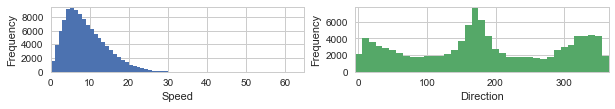

In [5]:
plot_speed_and_angle_distribution(df.speed, df.dir)

In [6]:
# Dir [10,360]=> [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360 if x < 999 else x) 
df['month'] = df['date']%10000//100
# Convert Windrose coordianates to Polar Cooridinates 
df['dir_windrose'] = df['dir']
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360 if x < 999 else x)
df.describe()

date      speed_max          speed            dir  \
count  1.092650e+05  109265.000000  109265.000000  109265.000000   
mean   2.006375e+07      15.388826       8.939517     182.432078   
std    3.883085e+04      44.835895       5.314807      99.879562   
min    2.000010e+07       0.000000       0.000000       0.000000   
25%    2.003062e+07       8.000000       4.910000      95.710000   
50%    2.006111e+07      13.000000       7.940000     172.500000   
75%    2.010030e+07      19.000000      12.130000     276.500000   
max    2.013053e+07    2359.000000      64.200000     359.980000   

                HrMn          month   dir_windrose  
count  109265.000000  109265.000000  109265.000000  
mean     1149.735963       6.382803     184.784231  
std       691.784248       3.467497     107.063300  
min         0.000000       1.000000       0.000000  
25%       600.000000       3.000000     101.800000  
50%      1100.000000       6.000000     176.400000  
75%      1700.000000       9.000000     288.410000  
max      2300.000000      12.000000     359.990000

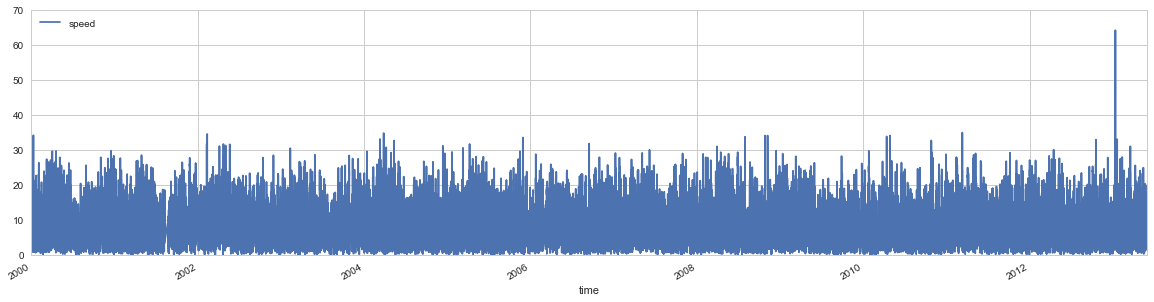

In [7]:
df.plot(x='time', y='speed',legend=True,figsize=(20,5))

### 1.2.1 Unit Detection

In [8]:
if 'knot_unit' not in globals():
    df['decimal'] = df.speed % 1
    df.decimal.hist(alpha=0.5, label='m/s', figsize=(4, 3))
    knot_unit = True if len(df.query('decimal >= 0.2')) / len(df) > 0.3 else False

    if knot_unit:
        df['speed'] = df['speed'] * 1.943845
        df['decimal'] = df.speed % 1
        df.decimal.hist(alpha=0.5, label='knot')
        # need more elaboration, some is not near an integer
        df['speed'] = df['speed'].apply(lambda x: int(round(x)))
    plt_configure(xlabel='Decimal', ylabel='Frequency', legend={'loc': 'best'}, title='Decimal Distribution')
    df.drop(['decimal'], 1,inplace=True)
print(knot_unit)

True


### 1.2.2 Sampling Type Selection

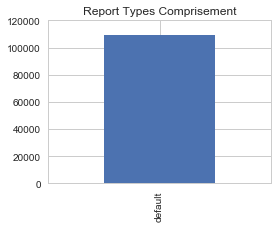

In [9]:
sample_type = df.query('date > 20000000')['type']
sample_type.value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement', figsize=(4,3))

report_type_most_used = sample_type.value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.2.3 Sampling Time Selection

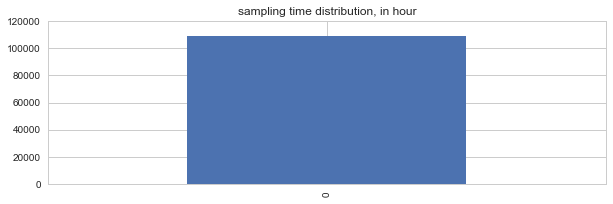

In [10]:
df['sample_time'] = df.HrMn % 100 
sample_time = df.query('date > 20000000')['sample_time']
sample_time.value_counts().plot(
    kind = 'bar', title = 'sampling time distribution, in hour', figsize=(10,3))

# Need more elaboration
sample_times = sample_time.value_counts()[sample_time.value_counts() > 2000]
sample_times = sample_times.index.tolist()
df = df.query("sample_time in @sample_times")
df.drop(['sample_time'], 1,inplace=True)

In [11]:
df['HrMn'].value_counts().sort_index()

0       4545
100     4552
200     4552
300     4548
400     4542
500     4552
600     4553
700     4550
800     4547
900     4568
1000    4569
1100    4566
1200    4571
1300    4572
1400    4575
1500    4566
1600    4544
1700    4539
1800    4531
1900    4535
2000    4543
2100    4552
2200    4550
2300    4543
Name: HrMn, dtype: int64

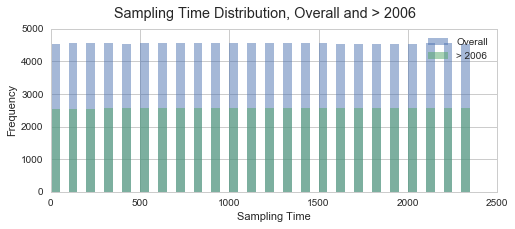

In [12]:
MID_YEAR = (min(df.date)//10000+max(df.date)//10000)//2
bins=arange(0, 2400+100, 50)

df['HrMn'].plot(kind='hist', alpha=0.5,bins=bins, label='Overall')

df.query('date > @MID_YEAR * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5, bins=bins, label='> %s' %  MID_YEAR )

plt_configure(xlabel='Sampling Time', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3), 
              title = 'Sampling Time Distribution, Overall and > %s ' %  MID_YEAR)

## 1.3 Data Wrangling

### 1.3.1 Artefacts

#### 1.3.1.1 wrong direction record

In [13]:
if integer_data:
    display(df.query("(dir % 10 >= 0.1) & (dir != 999)"))
    df = df.query('(dir % 10 <= 0.1) | (dir == 999)')

#### 1.3.1.2 sudden increase in speed

date  speed_max  speed     dir  HrMn     type wind_type  \
105972  20130111      162.0  64.20  324.11  1900  default   default   
105971  20130111      136.0  40.13  339.89  1800  default   default   
90488   20110311       51.0  34.93  151.10  1800  default   default   
33443   20040327       51.0  34.77  288.96  1100  default   default   
105970  20130111      160.0  34.55  327.65  1700  default   default   
16749   20020211       53.0  34.52  146.81  1500  default   default   
16748   20020211       51.0  34.22  154.88  1400  default   default   
209     20000110       49.0  34.16  123.77  1700  default   default   
70979   20081106       48.0  34.09  113.76  2100  default   default   
70714   20081026       51.0  34.08  133.34  1000  default   default   

                      time  month  dir_windrose  incre  incre_reverse  
105972 2013-01-11 19:00:00      1        125.89  24.07          46.48  
105971 2013-01-11 18:00:00      1        110.11   5.58         -24.07  
90488  2011-03-11 18:00:00      3        298.90   1.96           5.49  
33443  2004-03-27 11:00:00      3        161.04   6.17          24.53  
105970 2013-01-11 17:00:00      1        122.35  14.22          -5.58  
16749  2002-02-11 15:00:00      2        303.19   0.30           3.06  
16748  2002-02-11 14:00:00      2        295.12   3.60          -0.30  
209    2000-01-10 17:00:00      1        326.23   5.51           5.28  
70979  2008-11-06 21:00:00     11        336.24   3.90           1.82  
70714  2008-10-26 10:00:00     10        316.66   3.99           0.07

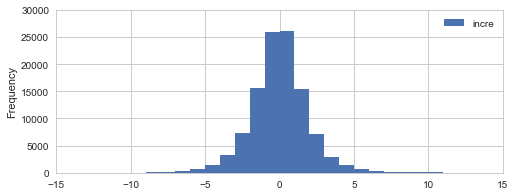

In [14]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True, figsize=(8, 3))

In [15]:
incre_threshold = 20 if knot_unit else 10
print('sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )')))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

# Check the max speed
display(df.sort_values(by='speed',ascending=False).head(10))
df.drop(['incre', 'incre_reverse'], 1, inplace=True)

sudden increase number 1


date  speed_max  speed     dir  HrMn     type wind_type  \
105971  20130111      136.0  40.13  339.89  1800  default   default   
90488   20110311       51.0  34.93  151.10  1800  default   default   
33443   20040327       51.0  34.77  288.96  1100  default   default   
105970  20130111      160.0  34.55  327.65  1700  default   default   
16749   20020211       53.0  34.52  146.81  1500  default   default   
16748   20020211       51.0  34.22  154.88  1400  default   default   
209     20000110       49.0  34.16  123.77  1700  default   default   
70979   20081106       48.0  34.09  113.76  2100  default   default   
83178   20100428       49.0  34.08  290.86  1300  default   default   
70714   20081026       51.0  34.08  133.34  1000  default   default   

                      time  month  dir_windrose  incre  incre_reverse  
105971 2013-01-11 18:00:00      1        110.11   5.58         -24.07  
90488  2011-03-11 18:00:00      3        298.90   1.96           5.49  
33443  2004-03-27 11:00:00      3        161.04   6.17          24.53  
105970 2013-01-11 17:00:00      1        122.35  14.22          -5.58  
16749  2002-02-11 15:00:00      2        303.19   0.30           3.06  
16748  2002-02-11 14:00:00      2        295.12   3.60          -0.30  
209    2000-01-10 17:00:00      1        326.23   5.51           5.28  
70979  2008-11-06 21:00:00     11        336.24   3.90           1.82  
83178  2010-04-28 13:00:00      4        159.14   0.51           3.17  
70714  2008-10-26 10:00:00     10        316.66   3.99           0.07

### 1.3.2 0 Speed

In [16]:
with_too_many_zero, null_wind_frequency = is_with_too_many_zero(df.query("(date >= 20050000)"))
delete_zero = with_too_many_zero
if delete_zero:
    df = df.query('(speed > 0)')
print(delete_zero, null_wind_frequency)

False 0.0156712769934


### 1.3.3 Direction re-aligment and 999
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [17]:
display(df['dir'].value_counts().sort_index())
effective_column = df.query('dir < 999')['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()
if integer_data:
    SECTOR_LENGTH = 360/len(effective_column) 
else: 
    SECTOR_LENGTH = 10
print(len(effective_column), SECTOR_LENGTH)

0.00      1
0.02      2
0.03      1
0.06      1
0.07      1
0.08      1
0.09      1
0.10      1
0.11      1
0.12      5
0.13      3
0.14      4
0.15      2
0.17      1
0.18      3
0.19      1
0.20      2
0.21      1
0.23      3
0.26      1
0.27      1
0.28      4
0.29      2
0.30      3
0.31      5
0.32      1
0.34      1
0.35      2
0.36      3
0.37      2
         ..
359.64    2
359.65    1
359.66    2
359.67    2
359.68    1
359.69    1
359.70    3
359.72    1
359.73    2
359.74    3
359.76    1
359.77    2
359.78    2
359.79    3
359.80    2
359.82    3
359.84    1
359.85    1
359.86    3
359.87    3
359.88    2
359.89    3
359.90    3
359.91    1
359.92    1
359.93    1
359.94    1
359.96    2
359.97    2
359.98    1
Name: dir, dtype: int64

1 10


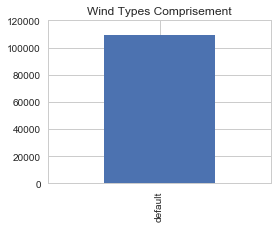

In [18]:
df=realign_direction(df, effective_column)
df=fill_direction_999(df, SECTOR_LENGTH)

### 1.3.4 Time Shift Comparison

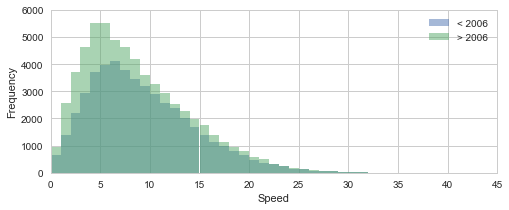

In [19]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, max(df.speed) + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='> %s' % MID_YEAR)

plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Speed', ylabel='Frequency', legend=True, figsize=(8, 3))

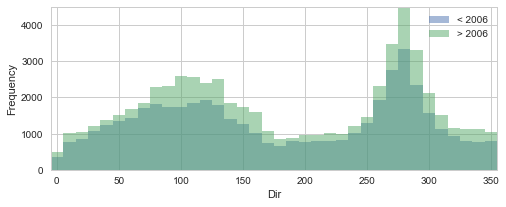

In [20]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Dir', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3),tight='x')

2000 - 2004


D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


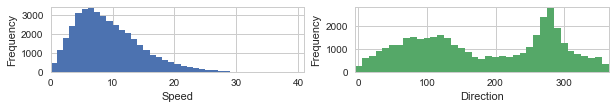

2005 - 2009


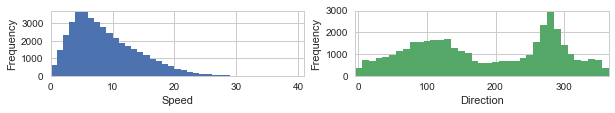

2010 - 2013


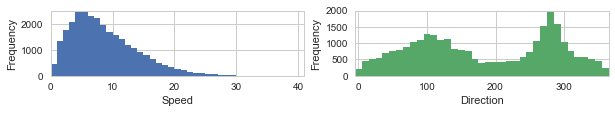

In [21]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
check_time_shift(df)

## 1.4 Re-distribute Direction and Speed
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [22]:
if integer_data:
    df = randomize_angle(df, DIR_REDISTRIBUTE, SECTOR_LENGTH)

In [23]:
if integer_data:
    if delete_zero:
        redistribute_method = 'down'
    else:
        redistribute_method = 'up'

    df, speed_redistribution_info = randomize_speed(df, redistribute_method)

## 1.5 Generate (x,y) from (speed,dir)

In [24]:
# Cook orientation
# df['dir']= (df['dir'] + 180)%360

In [25]:
# There might be a small dot in the centre, which is due to too many zero (more than 1 speed) in center
# Scatter plot in matplot has performance issue, the speed is very slow
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)

# 2. Re-select Data and Configs

## 2.1 Data Overview

In [26]:
## Summery of the data selection
print('Knot unit?', knot_unit)
print('Report type used:', report_type_most_used)
print('Sampling time used:', sample_times)
if 'speed_redistribution_info' in globals():
    print('Speed redistribution info:', speed_redistribution_info )

df_all_years = df # for later across-year comparison
df = df_all_years.query('(date >= 20100000) & (date < 20150000)')
# df = df.query('(HrMn == 0) and (speed >= 0.5) and (date%10000 > 900) and (date%10000 < 1000)' )
df.describe()

Knot unit? True
Report type used: default
Sampling time used: [0]


date     speed_max         speed           dir          HrMn  \
count  2.878200e+04  28782.000000  28782.000000  28782.000000  28782.000000   
mean   2.011311e+07     14.219373      8.687160    182.757129   1150.145925   
std    1.000365e+04      8.090569      5.362492    100.198360    690.920391   
min    2.010010e+07      1.000000      0.020000      0.060000      0.000000   
25%    2.010111e+07      8.000000      4.630000     96.642500    600.000000   
50%    2.011092e+07     13.000000      7.630000    169.990000   1200.000000   
75%    2.012073e+07     19.000000     11.820000    277.707500   1700.000000   
max    2.013053e+07    160.000000     40.130000    359.970000   2300.000000   

              month  dir_windrose             x             y  
count  28782.000000  28782.000000  28782.000000  28782.000000  
mean       6.105448    186.167199     -0.262583      0.504867  
std        3.496075    107.464964      5.822260      8.366787  
min        1.000000      0.000000    -31.439064    -31.846168  
25%        3.000000    105.052500     -3.115382     -4.924735  
50%        6.000000    176.060000      0.242468      0.332379  
75%        9.000000    290.907500      3.188066      6.018183  
max       12.000000    359.980000     37.683445     28.914194

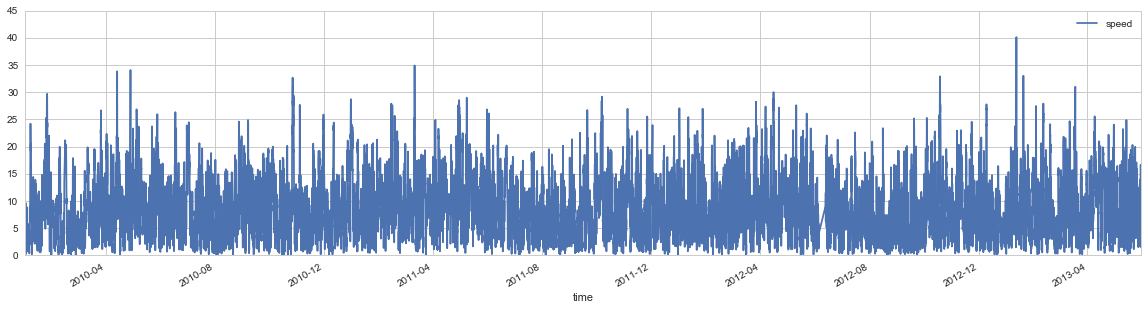

In [27]:
df.plot(x='time', y='speed',legend=True,figsize=(20,5))

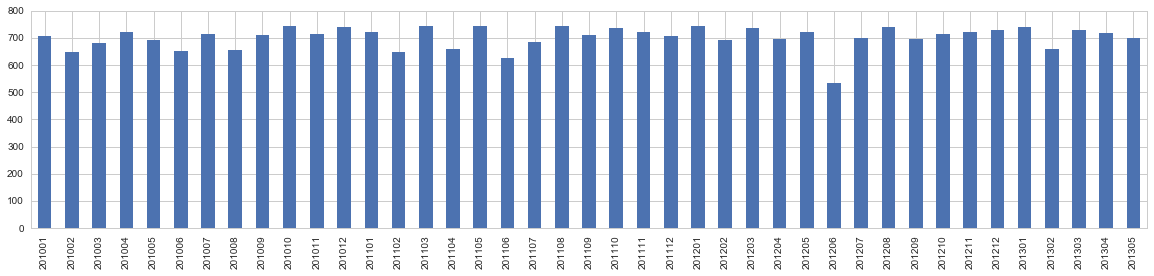

In [28]:
df['date'].apply(lambda x: str(x)[:-2]).value_counts().sort_index().plot(kind='bar', figsize=(20,4))

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


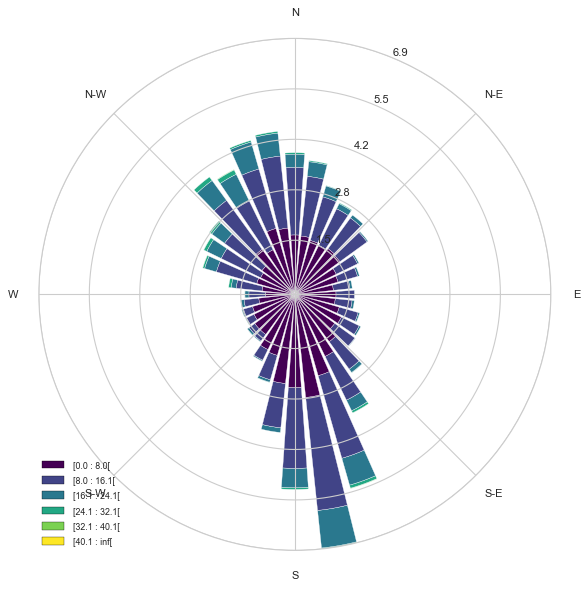

In [29]:
# 90 degree is east
ax = WindroseAxes.from_ax()
viridis = plt.get_cmap('viridis')
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=viridis)
ax.set_legend()

In [30]:
if len(df) > 1000000:
    bins=arange(0,362)
    df['dir'].hist(bins=bins, normed=True,alpha=0.5,label='min')
    
    df = df_all_years.sample(n=500000, replace=True)    
    df['dir'].hist(bins=bins, normed=True,alpha=0.5,label='min resmapled')
    plt_configure(legend=True, figsize=(20,4))

In [31]:
# Histogram comparison
if len(df) <= 300000:
    ax, _params = WindAxes.from_ax().pdf(df.speed, bins=arange(0, df.speed.max()))
    plt_configure(figsize=(4,3),xlabel='V',ylabel='PDF')

    # CDF comparison
    fig,ax = plt.subplots()
    ecdf = sm.distributions.ECDF(df.speed)
    x = linspace(0, df.speed.max())
    y = ecdf(x)
    plot(log(x), log(-log(1-y)),'o', label='ECDF')

    k_shape, _, lamb_scale = sp.stats.weibull_min.fit(df.speed, loc=0)
    y=1-exp(-(x/lamb_scale)**k_shape) # cdf
    plot(log(x), log(-log(1-y)),'-', label='Weibull')
    plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'},figsize=(4,3))
    align_figures()
    print(k_shape, lamb_scale)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: divide by zero encountered in log


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAToAAADlCAYAAADDXTsSAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAMTQAADE0B0s6tTgAAIABJREFUeJzt3XtcVHX+x/HXMDMIgoKogJcy0tJ0UUtD2S1TSzcEBd0u
P00s2yxL183S1MhMS93QtFyrrdQ0V3O9JgRkamqKipe8YJp5TVHkKghemOvvj5EJAuQiw4Ezn+fj
wcM558yc7+er45vvuWusVqsVIYRQMRelCxBCCEeToBNCqJ4EnRBC9STohBCqJ0EnhFA9CTohhOrp
lC6gOlksFkwmEy4uLmg0GqXLEUJUI6vVisViQafT4eJSuTGaqoLOZDKRnJysdBlCCAcKDAzE1dW1
Up9RVdAVpnz79u0r/RdRl5nNZpKTkwkMDESr1SpdTo2RfjtXvw0GA0ePHq30aA5UFnSFm6tardap
vgCFpN/Oxdn6XdjXquyWkoMRQgjVk6ATQqieqjZda9IfR89yawQhai8Z0QkhVE9GdNVMRnpC1D4y
ohNCqJ4EnRBC9STohBCqJ0EnhFA9CTohhOpJ0AkhVE+CTgihehJ0QgjVc3jQJSQkEBoaSt++fZk/
f36J5WlpaURGRhISEsKwYcPIysoCbLdkef311wkLC2PAgAHs3LnT0aUKIVTKoUGXkZFBdHQ0S5cu
JS4ujn379rF9+/Zi75k6dSqDBg0iISGBAQMGMH36dADWr1+PyWTi22+/ZdasWUycONGRpQohVMyh
QZeYmEj37t3x8fFBr9cTERFBfHy8fbnRaCQpKYmwsDAAIiIi2Lp1K0ajEYvFQkFBAWazmYKCAtzc
3BxZqhBCxRx6rWt6ejq+vr72aV9fX9LS0uzTOTk5eHh4oNfrbcXodHh6epKdnc3AgQNZt24dDz/8
MFeuXGHOnDkVbtdsNmM2m6uvI6UqfsNDs9mM1WqFO3fDndvhjl3gnsWz69rQtnFbBrYbyL2N73VI
JYV9dXyfaxfpt3P2uyocGnQWi6XEvKJ3By1tOdhuiT5//nw6d+7M119/zdmzZ3nuuefo0KEDLVq0
KLfdo0ePVr3oCutSbCpuZxzvJ78Pzxffl/jVYdv05C2T6dO8D3+/5+/c3eBuh1TkrM/LkH6L8jg0
6Pz9/dmzZ499Oj09HX9/f/u0j48P+fn5mEwmdDodJpOJq1ev4u3tzebNm5k7dy4ajYaAgAA6derE
4cOHKxR0Nf7MiC6f8X8/juW66TrkNYMDwyElGPKasey74+xO2c2/Exex4eIGNpzfDBvmwp5RmEyl
B31lOeszBKTfztXvwmdGVIVDgy44OJh58+aRmZmJl5cXMTExDB482L5cr9cTFBREbGwsAwcOJDY2
lqCgIPR6Pe3atWPDhg3ce++9ZGdnc+TIEcaOHVuhdmv0XvoPfAH9R3LDpGHUg6P4eNB0KPCyLx7S
sQtDOg7h30++DX+Jhj/Phn7/gOb7MFg+xV3vXm2lONszBApJv53D7fTVoQcj/Pz8GD9+PMOHDycs
LIy2bdvSp08foqKi2Lx5MwBTpkxh/fr1hIaGsmrVKiZPngzApEmTOHr0KP369ePZZ5/ln//8JwEB
AY4st/I6rIT+L4FVw38H/Zf5/eYXC7lirjWBjdGwLB6ue0PnJYR9HcYN042arVkIJ6SxWtVza0iz
2czBgwer9NzHytLcsRuG9wCtEb79BOvel23zy7jxZrH5jU5BZF/wOU1423BWPbkKvVZf5VoK+925
c2en+g0v/XaufhsMBpKTk6vUb7kyogoKTAUQ/rwt5La+DftertwKLreGrzbRvEFz1h9fj+uTz6PR
WNFoSgalEOL2SdBVwYztM6DpMbjYBX6cXLWV5ASwMXIjXGsMnf5r23cnhHAICbpKSk5LZuaOmWDW
wfqFYKn68Zz2TdvD/9aCRQuPTYJWP1ZjpUKIQhJ0lWC1Wnkl/hWMFiMkvgFpnW5/pb/1gE0zwcUM
TzwNnpduf51CiGIk6Cphy9kt7Di3gzsa3lH1TdbS7BwHv4RDg0sQ8RwqOj4kRK0gQVcJ07fbbjgw
4S8TwFSd195q4Jsv4UoLaLOBxQcXV+O6hRASdBW08/xOfjjzA/6e/jx///PV38CNRhD7GQBjN4zl
wpUL1d+GEE5Kgq6CCkdz44LHVevVDMWcCIVDkeQW5PLSty/JJqwQ1USCrgIOXjpI/Il4Grs35qWu
Lzm2se8+xN/Tn7gTcaw9ttaxbQnhJCToKuDz/Z8DMOrBUXi6ejq2ses+zP3rXABe+/41rhmvObY9
IZyABF05NPrrfLpjOVg1TBvogH1zpXi6w9P0aNWDc7nn+NeOf9VIm0KomQRdedp9A265cKY35Laq
kSY1Gg3zHp+Hi8aF6MRoTl8+XSPtCqFWEnTluX+R7c8DNTOaK9TJvxMvd32ZAnMB4zeOr9G2hVAb
Cbpb+C3nN7h7M9zwgmMDa7z9ab2m4e3mzdpja9l1fleNty+EWkjQ3cKSQ0tAY4XkwWBy0Cklt+Dj
7sObD70JwBub3pDTTYSoIgm6MlitVpYeXmqbODhcsTr+0e0f3NHwDnac20Hsr7GK1SFEXSZBV4aj
GUc5mX0SLt8FFx5UrA43nRvv9noXgImbJmKymBSrRYi6SoKuDN/88o3txS8RgLJ3wxzacSiBvoEc
yzzG8uTlitYiRF0kQVeG9cfX214cD1eshsI7Duu0WpI/so3qpm2bhtFsVKwmIeoiCbpSXLhygb0X
9+Lj7gPnHlK6HJvjA+jSrAunLp/iq0NfKV2NEHWKBF0pYo7HABB2b9ht3UG4emmY1msaAO/++C4G
s0HheoSoOyToSvHNcdv+uYi2EQpXUlxImxC6tejGb7m/sejAIqXLEaLOkKD7g9wbuWw5swU3nRt9
W/dVupxiNJrfR3Uzd8yUfXVCVJAE3R98f+p7jBYjj939GB6uHkqXU0Kfu/vQrUU3zuWe47+H/6t0
OULUCRJ0f7D5zGbAtplYG2k0Gt7q8RYAM3bMwGwxK1yRELWfBN0f/HDmBwB6B/RWuJKyhd4TSie/
TpzMPsnKn1cqXY4QtZ4EXRHnc89zIvsEzTyb0bZxW6XLKZNGoyHq4SjAdot3i9WicEVC1G4SdEUU
Hc1pNMpeDVGeQfcNol2Tdvyc8TPf/vqt0uUIUatJ0BXxw9nav9laSOuitT12EXh/5/tyZxMhbkGC
7iar1Von9s8VNSRwCC0btiTpQhIHsg8oXY4QtZYE3U0ns0+SciWFAO8A7vK+S+lyKsRV68pr3V8D
YMmpJQpXI0Tt5fCgS0hIIDQ0lL59+zJ//vwSy9PS0oiMjCQkJIRhw4aRlZUFgMFg4L333iM8PJzQ
0FB27Njh0Drr2miu0IguI2jk1ojE9EQOpx1WuhwhaiWHBl1GRgbR0dEsXbqUuLg49u3bx/bt24u9
Z+rUqQwaNIiEhAQGDBjA9Om2B0UvWLCAy5cv88033/Dhhx8yceJELBbHHF3UaGDk+7agW/hWb2r5
cYhiPF09eaXrKwDM2jlL4WqEqJ0cGnSJiYl0794dHx8f9Ho9ERERxMfH25cbjUaSkpIICwsDICIi
gq1bt2I0GklISGDEiBFoNBruueceFi9e7MAd7lZo9aPt5dmeDmrDcUY/OJp6LvVYeXQl53LPKV2O
ELWOQ2/NkZ6ejq+vr33a19eXtLQ0+3ROTg4eHh7o9XpbMTodnp6eZGdn89tvv7F//36ioqLQarW8
9tprtGnTpkLtms1mzOZKXDHglQINLtnuJpzX3L4OG22JdVfH/N+XlTX/VusqzsfNh/539Gf1b6uZ
s2sOH/T5oNT3qU3h30el/q1VwNn7XRUODbrSNjWLnp9W1qaoi4sLZrOZlJQUVq9ezfHjx3nhhRdI
SEigQYMG5bZ

1.67495195197 9.71858606859


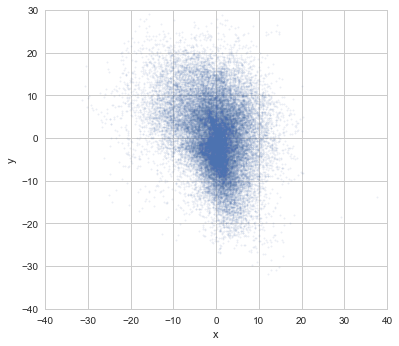

In [32]:
df.plot(kind='scatter', x='x', y='y', alpha=0.10, s=2)
plt.gca().set_aspect('equal')

## 2.2. Overview by Direction

In [33]:
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 10

In [34]:
original_incre, incre = SECTOR_LENGTH, rebinned_angle
start, end = -original_incre/2 + incre/2, 360

max_speed = df.speed.max()
max_count = max_count_for_angles(df, start, end, incre)
plot_range = [0, max_speed, 0, max_count*1.05]

for angle in arange(start, end, incre):
    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)   
    
    fig = plt.figure()
    title ='%s (%s - %s), %s' % (angle, start_angle, end_angle, len(sub_df)) 
    sub_df['speed'].hist(bins=arange(0, max_speed), alpha=0.5, label='Data')
    plt.axis(plot_range)
    plt_configure(figsize=(3,1.5), title=title)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAANIAAAB6CAYAAADK1g3BAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAEOZJREFUeJzt3XtMk9cbB/BvoSDEqrAwcdnEgQwZaBFv6BiYTY1zDBVv
Uy5m4piYmIHuAiogWnToposxyBAkOpyiU3AmXrZpUDMZbiDqwGtVUIdyUXBU7uX8/iC8PysVWjjY
l/J8EhL7ntP2KfXLad/3vOeVMMYYCCFdYmLoAggxBhQkQjigIBHCAQWJEA4oSIRwQEEihAOjClJj
YyPWrVsHDw8PeHh4YNOmTVCr1dz6A4BKpYKvry+qqqpe2CcmJgbDhg3T+Fm3bt0L+9+8eRMBAQFw
c3ODj48Pzp492/GL7cDixYvb1LBz584X9s/NzYWfnx/kcjlmz56Nf/75R2j77bffsHLlyk7XcuPG
DQwfPhznz5/X2P7HH39g+vTpkMvlmDFjht7tosKMSHx8PJsyZQrLz89n586dY56eniwhIYFbf8YY
UygU7Icffmi3z/z589n27dtZWVmZ8FNdXa21b21tLfP29mbR0dFMqVSyhIQENmLECFZUVNTxC26H
l5cXy8zM1KihpqZGa9+HDx8yd3d3tnXrVqZUKllsbCzz8PBgT548EfrMnj2bnT9/Xu86mpqa2KxZ
s5iTkxPLyckRtl+9epW5urqyhIQEVlRUxL799ls2atQoVlpaqlO72BhNkOrq6pibmxs7efKksC0j
I4NNmDCBqdXqLvdnjLGysjI2cuRIVlVV1W4t48aNY2fOnNGp7szMTDZhwgTW0NAgbAsMDGTx8fE6
3V+b6upq5uTkxJRKpU79t23bxmbOnCncbm5uZpMmTWJpaWkadQYGBupdS2JiIgsICGgTpOXLl7PQ
0FCN5/Tz82O///67Tu1iYzQf7a5evYra2lqMGzdO2DZmzBg8evQId+/e7XJ/ANi/fz/c3d0xYMCA
F9ZRXl6Oqqoq2Nvb61T3hQsX4O7uDjMzM2Hb2LFjkZ+fr9P9tVEqlZBKpbCzs9Opf35+PsaOHSvc
lkgkGD16tEYN7733HvLz83H9+nWd67h58yZ2796NtWvXtmn7888/MW3aNI3nzMjIwOTJk3VqFxuj
CVJpaSksLS3Rr18/Ydurr74KAHj48GGX+wPA6dOn4eXl1W4dSqUSEokEycnJmDhxIj788EOkpqai
ublZa/+ysjIMHDhQY5uNjQ1KS0vbfZ6OapDJZIiMjMS7776LGTNmIDMz84X9dalhwIABGDFiBM6c
OaNTDWq1GpGRkQgLC8OgQYM02qqrq/H48WOYmZlh2bJleOedd7BgwQIhuB21i5HRBKm2thZ9+vTR
2GZubg4AaGho6HJ/tVqNK1euwNHRsd06bt++DRMTE9jZ2WHHjh0IDg5GQkICUlJS9KpbWw26unXr
Furq6jBhwgSkpKRg5syZiI6OxtGjR7tUg6OjIwoKCnSqISUlBTKZDB9//HGbtqdPnwIA4uLihBpH
jBiBTz75BPfv3++wXYykhi6AFwsLizZvfOttS0vLLvevqqqCWq2GtbW1sO3TTz9FXl6ecPvo0aPw
9/eHj48PrKysAADDhg3DkydPsGvXLnz22Wc612FhYaH1dfr4+KCkpES4re2v9JdffonQ0FDhI6iz
szPu3buHtLQ0+Pj4dLoGKysr3L59W2tdz1IqlUhNTcXBgwchkUjatEulLf/tPvroIwQEBAAAXFxc
kJOTg59//hlBQUHtti9fvrzDGl42ownSoEGDUFNTA5VKBZlMBqDl+woA2Nradrl/63+IZz+irV+/
HnV1dcLtgQMHQiKRCCFq5ejoiIqKCqjVapiammq02draCs/bqry8XGsNALBjxw40NTVpbWtlamra
5nvc0KFDcfr0aa39da1BrVbDxKTjDzEnTpxAdXU1pk+frrE9JCQEM2fORExMDMzMzNqM7g4ODigp
KYGVlVW77WJkNB/tnJ2dYWlpqTFC5ObmwsbGRuuXbn37W1tbQyqVorKyUthma2uLIUOGCD9SqRTr
16/HokWLNO5bUFCAN998s02IAMDd3R35+fka4cjNzYW7u7vW1/n6669rPKc2y5Ytw+rVqzW2FRYW
wsHBQWt/d3d35ObmCrcZY8JOkGdVVlYK3yPbExgYiOPHj+Pw4cM4fPgw9u3bB6Dlo1pYWBikUinc
3NxQWFiocb9bt25h8ODBHbaLkqF3G/KkUCjY+++/z3Jzc1l2djbz9PTUOOZTWVnJKisrde7/vDlz
5rCkpKR2a8jJyWHOzs4sKSmJFRcXs8zMTDZy5Ej2yy+/MMZajquUlZWx2tpaxhhjKpWKeXp6ssjI
SKZUKtn27duZXC5nd+/e7fTvITMzk7m4uLCDBw+y4uJitmvXLubq6sr+/vtvxhhj9fX1rKysjNXX
1zPGGHvw4AFzc3NjmzdvZkqlkq1du5aNHz+e/ffffxqP6+fnx1JTUxljLce/ysrKWFNTU4f1qFSq
Nru/s7KymKurK0tPT2dFRUVs48aNzM3Njd27d0+ndrGRMGa4E/ueHQ14aGhowO7du5GTkwMzMzN4
e3tj/vz5wscRhUIBAIiOjtap//MyMjJw8+ZNREREtFvHX3/9hYyMDDx48ADW1tbw9fXFpEmTALR8
ZAoLC8OSJUswceJEAEBRURFSU1NRXFwMW1tbBAYGQi6Xd+l3cfLkSRw/fhwVFRWwtbXF3LlzhV3c
V65cQVxcHKKiouDi4gKgZdT88ccfUVpaCjs7OyxatEhjBKupqcGSJUuwadMmvPbaazhz5gySkpKw
devWDkepuro6BAcHazwfAGRnZ+PQoUOoqKjA4MGDERgYCGdnZ53bu9vo0aN172zIFOfm5hry6XXW
WufDhw+Zm5sbKy8vN3BF2nXn7zM9PZ0tXLhQY1tISIjev4ue9p7rymi+I70Mtra28PPzw/79+w1d
ykvFGMO+ffuwdOlSYduFCxdgYmICGxsbA1YmHhQkPa1YsQLHjh1rd9KqsTlx4gScnJwwfvx4YZtc
LkdiYqIBqxIXo9n9/bL069fvhQc2jdW0adM0pusA/z8WRFrQiEQIBxQkQjigIBHCAQWJEA50CtKl
S5eEiYRXrlyBl5cXgoKCEBQUhGPHjgEADhw4gFmzZmHevHnIysrqvooJEaEOd70kJyfjyJEjwozo
wsJCLFq0CMHBwUKf8vJypKWl4dChQ6ivr4e/vz88PT2F0xIIMXYdjkh2dnbYtm2bcLugoACnT59G
QEAAVq1aBZVKhcuXL8Pd3R3m5ubo168f7OzscO3atW4tnBAx6XBEmjp1qsbJVHK5HHPnzsXw4cOR
mJiIhIQEODs7a5xp2rdvX6hUKp0K4D3frrtQnfz0hBr1pfdRtSlTpqB///7CvxUKBcaMGSOc1Qi0
nAH5bLDao9fEQAPJy8ujOjnpCTUC+odd7712ixcvxuXLlwG0LFDh6uoKuVyOvLw81NfXo7q6Grdu
3YKTk5O+D01Ij6X3iBQbGwuFQgEzMzPY2NhAoVBAJpMhKCgI/v7+YIxh+fLlbdYAIMSY6RSkN954
AwcOHAAAuLq6Ij09vU2fefPmYd68eXyrI6SHoAOyhHBAQSKEAwoSIRxQkAjhgIJECAcUJEI4oCAR
wgEFiRAOKEiEcEBBIoQDChIhHFCQCOGAgkQIBxQkQjigIBHCAQWJEA70XteuuLgYCxYsgL+/P9as
WSNcU5XWtSO9WYdBSk5ORlRUFOrr6wEA33zzDcLDw7F3714wxnDq1ClhXbv09HTs3LkTW7Zs6dLl
7QnpaTo81bx1Xbuvv/4aQMsCkePGjQMAeHt749y5czAxMRHWtTM3NxfWtdPl8o09ZWkmqpOfnlCj
vvRe144xBol

## 2.3 Overview by Month

In [35]:
month_incre = 1
current_df = df.query('speed>=1')
for month in arange(1, 12+month_incre, month_incre): 
    end_month = month+month_incre
    sub_df = current_df.query('(month >= @month) and (month < @end_month)')
    if len(sub_df) > 0:
        if month_incre == 1:
            title = 'Month: %s' % (month)
        else:
            title = 'Month: %s - %s ' % (month, end_month-1)
        ax = WindroseAxes.from_ax()
        ax.bar(sub_df.dir_windrose, sub_df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=plt.get_cmap('viridis'))
        plt_configure(figsize=(3,3), title=title)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOwAAADxCAYAAADIm1tRAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAMTQAADE0B0s6tTgAAIABJREFUeJzsnXl4XGX59z+z7zOZyb5vTZOmTfeFLtCVtkChgoKogAiC
sgiICihgFUFA+1Y2AZWdX1GoyFJBEFqgLW3pQqFLmjT7vk4ymX0/7x9xpg1J2qQ5War5XleuqzNz
znOec3q+z3Pvt0QQBIFxjGMcZwSkoz2BcYxjHAPHOGHHMY4zCOOEHcc4ziCME3Yc4ziDME7YcYzj
DMI4YccxjjMI44T9H8C45+6/B+OEHQEsW7aM/Px8HnrooT5/b2hoID8/n/z8fDo6OkS99ocffsi6
deuinx9//HFmzJgh6jWcTidLly7lvffeE3XccfTGOGFHCBKJhA8++KDP395///1hu+6LL75IS0vL
sI3vdDq58cYbaWxsHLZrjOM4xgk7QpgxYwb19fUUFxf3+u29994jPz9/FGY1NOzZs4dLL72UkpKS
0Z7K/wzGCTtCmDRpEunp6b1208bGRg4dOsTq1at7nfPBBx/w9a9/nenTp7N48WIeeeQRgsFg9Pdl
y5bxl7/8hXXr1jF37lxmzpzJnXfeidPpBODKK69kz549fPzxx+Tn51NfXx89991332XVqlUUFRVx
ySWX8Pnnn0d/q6+vJz8/n8cff/yk93TTTTcxceJEnnnmmdN6JuMYPMYJO4JYuXJlL7H4/fffZ9q0
aSQlJfX4/tVXX+Xmm29m6tSpPPHEE1xxxRU899xz3HXXXT2O+9Of/oTdbmfDhg3cdtttvPPOOzz1
1FMArFu3jsLCQmbOnMmrr75KQkICAB6Phz/84Q/ccsstPProo3g8Hn70ox9FF4OEhAReffVVLr30
0pPez8aNG3n00UexWCxDei7jGDjkoz2B/yWsXr2aZ599loqKCnJzc4Fucfi8887rcVwoFOKRRx7h
ggsuiBqMFi1ahMFgYN26dXz/+9+noKAAgKSkJDZs2IBEImHRokV88sknPPPMM8ydO5fFixej1+vR
arXcfvvtvPTSS0C31fj3v/8906dPByAYDPKjH/2I8vJyCgoKUCqV0d9OhokTJ4r2bMYxMIzvsCOI
oqIikpOT+fe//w1AU1MTBw8eZNWqVT2Oq6yspKOjo5eYfMEFFwCwb9++HmNKJJLo5/j4eKB7d3U4
HH3OQyaTMXXq1Ojn1NRUgH6PH8fYwThhRxASiaSHWPz+++8zdepUkpOTexzX1dUFQGxsbI/vDQYD
SqUyqqMCaDSaXteQyWQsWrSIBx98sM95qFQqpNLj//WRf4fD4dO8s3GMFMYJO8JYuXIlR44cob6+
nvfff7+XOAwQExMDgNVq7fG93W7H7/dHfz8Z7rrrLnbt2oXNZhNn4uMYExgn7Ahj5syZxMfH87e/
/Y0vv/yylzgMkJ2djdls7hWI8O6770bHOBX0ej2/+c1vqK6u7mFZHseZjXGj0whDKpVy7rnn8sIL
L0R12q9CJpNx880385vf/AaTycTy5cspLS3l8ccfZ/Xq1QM29ixatIj4+HgOHDiARqPB5/MN6Dy/
309xcTFJSUm9rNfjGF2M77CjgJUrVxIIBPr0vUZwxRVX8MADD/DZZ5/xwx/+kI0bN/K9732P9evX
D+pa9913Hx6Ph/b2dsrLywd0TmtrK9/85jfZtGnToK41juGHZLym038X6uvrueqqq9i6dWv0ux07
dnDttdeyZcsW0tLSRnF24xgqxgk7jnGcQRgXiccxjjMI44QdxzjOIIwTdhzjOIMw7tb5L0A4HCYU
CkUrSwiCEP23RCLp8SeTyXqEMo4G3nrrLf785z8DcM4553DnnXf2+H3Xrl08/PDDhEIhUlNTefjh
hzGZTKMx1TGHcaPTGIYgCAQCAfx+P4FAIPrn8/mi3wWDwUGHFMpkMhQKBQqFAqVSiVKpjH5WKBSo
VCrk8uFZyz0eD4sXL+Zf//oXJpOJb33rW/z4xz9mwYIFQHfiw9KlS3n++efJzc1l/fr1SKVSbr/9
9mGZz5mG8R12jEAQBPx+P263G5fLhcvlwu12Ew6HkUql0T+5XI5cLkej0WAymVCpVFHSRUgmlUoJ
hUJ88cUXTJ8+HYlEgiAIBINB/H4/Pp8vSvrINSPED4fDCIKAQqFAq9VGs320Wq0oJA6FQoTDYbxe
L3q9nlAohEqliv4uk8nYsmULCoUCv99PS0vLGZncP1wYJ+woIRgM4nA4epFTLpejUCjQaDTExsZi
MplQKBRDulYkuF8mk6FSqTAYDP0eKwgCHo+Hrq4uXC4X7e3tBAIBwuFwDxLrdDr0ev2gxWu9Xs+t
t97Keeedh0ajYc6cOb1CLRUKBUePHuWaa65BoVCM764nYFwkHkH4fD5sNhudnZ24XK6oaKrVajGZ
TJhMJmQymSjXOnGHFWNMv99PZ2cndrsdr9dLIBBAIpFgMpmIiYkZ8NxLSkq46667ePbZZzEYDPz0
pz9l6tSpfP/73+/z+FdeeYW3336bv/3tb0O+h/8GjO+wwwhBEHC73XR2dmKz2fD5fCgUCvR6Pamp
qSfd6cYalEoliYmJJCYmAt2Gro6ODqxWK7W1tYRCIXQ6HRaLJSqq94UdO3Ywf/78aOrgJZdcwiuv
vBIlrNvtZvfu3SxbtgyAr33ta/z+978fgTs8MzBOWJEhCEJUlLTZbITDYVQqFTExMSQmJg5ZvB0r
kEqlxMXFERcXB4DL5aK1tZXm5mbq6upQqVSYzWbi4+NRKpXR8woKCnj44Ye5+eab0Wq1bN26lcmT
J0d/l8vl3HPPPTz//PPk5+fzzjvvMHv27BG/v7GKccKKhFAoRGdnJy0tLfh8PlQqFUlJSSQkJPRI
Fv9vhU6nIzs7G+gW/VtaWrBarTQ3N2MymUhISMBgMLBo0SKKi4u55JJLUCqVTJkyheuvv567776b
ZcuWsXz5cjZs2MBdd91FOBwmKSmJ+++/f5TvbuxgXIcdIrxeL62trbS3tyOVSomJiSE1NXXUd1Kx
ddjThdPppKGhAZfLhVwuJzExkdjY2GFzG/23Y/ypnQYEQcBms9HS0oLL5UKtVpOZmYnFYhn1oISx
Br1eT35+PqFQiKamJpqbm2loaMBisZCQkIBWqx3tKZ5RGN9hBwFBEOjo6KChoYFQKIReryc9PR21
Wj3aU+uFsbLD9oXOzk4aGxujvti0tDR0Ot1oT+uMwPgOOwAIgoDdbqeuro5AIIDZbCY9PX3MEeFM
gdlsxmw24/F4qKmpoaSkJKpKjMXFbyxhnLCngNPppK6uDo/HQ0xMDJmZmeNEFQkajYaCggI8Hg9V
VVUcOXKE2NhYUlJSeliWx3Ec44TtBx6Ph/r6ehwOBwaDgaKiolE3JP23QqPRUFhYiNPppLq6msOH
D5OQkEBSUtK4ceorGH8aX0EwGKSuro6Ojg60Wi2TJk3qVft3HMMDvV7PlClT6OjooL6+nra2NpKT
k0lMTBw35v0H44Q9AZ2dndTU1CCVSsnLy8NoNI72lP4nYbFYsFgsNDY20tTUREdHBzk5OeP6LeOE
Bbp31ZqaGrq6uoiPjyc1NfV/IthhrCMlJYWEhATKy8spLi4mJSXlf363/Z8nbGdnJ9XV1SgUinHx
V0Rs3bqVJ554ArfbzaJFi7jnnnt6/N7a2so999xDS0sLGo2G9evX91nRUS6XU1BQQHt7e1RV+V/e
bf9nt5FgMEhFRQVVVVUkJCQwefLkcbKKhLq6OtatW8eTTz7J5s2bKS4u5uOPP+5xzB133MHSpUt5
6623WLt2Lb/73e9OOmZcXBxTp05FJpNRXFxMc3Mz/5MhBMIYQV1dnTBx4kTh448/7vH90qVLhbq6
uuhnv98vTJ8

## 2.4 Create input data, i.e. speed_set

In [36]:
SPEED_SET = array(list(zip(df.x, df.y)))
NUMBER_OF_GAUSSIAN = 3
FIT_METHOD = 'square_error'
DEFAULT_BANDWDITH = 1.5 if knot_unit else 0.7
fig_list = []

In [37]:
fit_limit = ceil(df['speed'].quantile(.95))
fitting_axis_range = arange(-fit_limit, fit_limit+1, 1)
print(fitting_axis_range)

FITTING_RANGE = []
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

[-19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2
  -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19]


In [38]:
plot_limit = ceil(df['speed'].quantile(.95))
PLOT_AXIS_RANGE = arange(-plot_limit, plot_limit+1, 1)

# 3. Kernel Density Estimation

In [39]:
sample = SPEED_SET
KDE_KERNEL = 'gaussian'
# KDE_KERNEL, bandwidth = 'tophat', 1

In [40]:
%%time
from sklearn.grid_search import GridSearchCV
# from sklearn.model_selection import GridSearchCV  ## too slow

# The bandwidth value sometimes would be too radical
if knot_unit:
    bandwidth_range = arange(0.7,2,0.2)
else:
    bandwidth_range = arange(0.4,1,0.1)

# Grid search is unable to deal with too many data (a long time is needed)
if len(sample) > 50000:    
    df_resample=df.sample(n=50000, replace=True)
    bandwidth_search_sample = array(list(zip(df_resample.x, df_resample.y)))
else:
    bandwidth_search_sample = sample

grid = GridSearchCV(neighbors.KernelDensity(kernel = KDE_KERNEL),
                    {'bandwidth': bandwidth_range}, n_jobs=-1, cv=4) 

grid.fit(bandwidth_search_sample)
bandwidth = grid.best_params_['bandwidth']
print(bandwidth)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


1.7
Wall time: 1min 6s


In [41]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH

kde = neighbors.KernelDensity(bandwidth=bandwidth,kernel = KDE_KERNEL).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print('bandwidth:', bandwidth, len(kde_result))
print(kde_result[:5])

bandwidth: 1.7 1521
[  1.57780848e-06   3.03769049e-06   4.54507331e-06   5.54877943e-06
   5.97620163e-06]


In [42]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))
colorbar_lim = 0, kde_Z.max()

plot_3d_prob_density(X,Y,kde_Z)

fig_kde,ax1 = plt.subplots(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x', ylabel='y',ax=ax1)

with sns.axes_style({'axes.grid' : False}):
    from matplotlib import ticker
    fig_hist,ax2 = plt.subplots(figsize=(4,3))
    _,_,_,image = ax2.hist2d(df.x, df.y, bins=PLOT_AXIS_RANGE, cmap='viridis',)
    ax2.set_aspect('equal')
    cb = plt.colorbar(image)
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
    plt_configure(ax=ax2, xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXtwI/d9J/jpbqDx4nv4GJJDckhIii6WbUlTjpNz5Lub
ZLa8KuccZ2w9spva2ErsXHbty9rOZmyfnSlpLMnZrK9yyUTnJKWtK7lcHluXxyrOViWyvOdaXTaW
RpnyjWQpEsnhGwRAgCTe/frdH+Dvx+5GN9ANdJMA1Z+qqSGBX3/7R6D709/3lyOEEAQIECDACQV/
3BsIECBAAD8RkFyAAAFONAKSCxAgwIlGQHIBAgQ40QhILkCAACcaAckFCBDgRCMguQABApxoBCQX
IECAE42A5AIECHCiEZBcgAABTjQCkgsQIMCJRkByAQIEONEISC5AgAAnGgHJBQgQ4EQjILkAAQKc
aAQkFyBAgBONgOQCBAhwohGQXIAAAU40ApILECDAiUZAcgECBDjRCEguQIAAJxoByQUIEOBEIyC5
AAECnGgEJBcgQIATjYDkAgQIcKIROu4NBDh+EEIgSRIURYEgCAiHw+B5HhzHHffWAgToGBwhhBz3
JgIcH2q1Gvb29tDf3w9ZlgEAm5ubGB4eRn9/P3ieD0gvQE8j0OTexlBVFZVKBZlMBolEAoqiIBwO
gxACQghUVYWiKJAkCRzHQRCEgPQC9BwCknsbghACRVGgqio4joOqqlhcXISqqgiFQtA0DeVyGZFI
BKHQ4SVCSa9Wq4HneQiCAEEQEAqFAtIL0LUIzNW3GTRNgyzLoF/71tYWcrkcZmdnIYoiJElCKpUC
x3GQZRmhUAjxeByxWAzxeByCIBjkUTkcxzGyC4VCDesCBDguBJrc2wTU/FRVFQCgKArW19ehaRrC
4TD6+/shSRKi0SjC4TAGBweRSCRQq9VQLpext7eH7e1tRnqU+PRkpigKCCGo1WpIp9OYmJiAKIoB
6QU4VgQk9zaApmlQFAWapoHjOBQKBWxsbGBkZAQDAwNYXV01rOc4DoQQcByHaDSKaDSKkZEREEJQ
rVZRqVSwu7uLVCqFcDjMCE9PeqVSCZIkMdKj5m2g6QU4agQkd8JB/Wg0mJBKpbC/v4+ZmRmmqTn1
WHAcx8hMT3rlchm7u7vY2tqCKIqIx+MghDBSBQ79gAHpBThqBCR3QqFpGlRVhaZpAABJkrC2tgZR
FJFMJllAoZNggZ706DmppqdpGtbW1hCJRJg/LxaLgefr+ecB6QU4KgQkdwKhaRqy2Sz29vYwOzuL
fD6PVCqF8fFxjIyMNBCbWZOj5qpb8DzP/HX7+/uYnJxkkdpcLodqtYpIJGIwb5uRXrFYxMDAACKR
SEB6AdpGQHInDNQ8BerEsb6+jkqlgvn5eUSj0Yb1fqZ98DyPaDSKeDwOoE6+lUoFlUoFOzs7qNVq
iEajTNOLRqMG0kun0wiFQlAUJdD0ArSNgOROCMy5b7Iso1gsYmhoCMlkkpGH3bGAv4QH1EkvkUgg
kUgAOCS9crmMbDbLSI9qejT4QTVLO/NWFMUgRy+ALQKSOwEw575ls1mk02mIoojp6emmx1qRQ7vm
qluYSY9WYNAqDEVRkEqlkEgkmKbXKpBBa28D0gtAEZBcj4Nqb0CdJDY2NqAoCk6fPo39/X1HMrol
H1wQBPT19aGvrw8AsLS0hIGBAUiShHQ6DVmWDZqeFenJsoxqtcpIj+M4hMPhwLx9GyMguR6F2Twt
FotYX1/H0NAQZmdnUSqVHJGXncbjBfF1KoPjOMTjcQwNDQE41PTK5TK2t7ehKAojvXg8jkgk0kB6
W1tbTEag6b09EZBcD0Kf+wYA29vbyOfzmJ6eRn9/P1vXLsl4QQB+kIhZ01MUhZFeKpWCoiiGdJVI
JML2YqfpBaR38hGQXA+BEIKdnR2Ew2FEo1HIsoz19XVwHIdkMolwOMzWOr1pj8r/5gdCoRD6+/sZ
setJb3d3F6qqsoBLJBIxBCj0pEd9epT4AtI7WQhIrkdAS7Py+TzzU21sbGB0dBSjo6MNN2Wn5NWL
xGdFepubm+x/VVUNzQb0pKdpGgvg6EkvFAohFAoFpNfDCEiuB6CqKmtoCQD5fB6SJGFubo7loLUL
fZ2q/rWTAEpQlPhkWTZoepqmMcKLx+MGDU5PerIso1AoYGJiIiC9HkRAcl0Mc3ChWq2iWCwiEong
tttuaxox7GUz1C+Ew2GEw2EMDAwAAGRZRrlcRqVSQS6XAyHEoOlR0lMUBeVymZm3HMcFml4PISC5
LoW+cwgA5HI5bG9vIxqNYnBwsGVKhFOS0/uo3B7b66AtpQYHB0EIMWh6uVwOABCLxVgjUb3Gq9f0
AtLrbgQk14XQ575pmobNzU1Uq1XMz8+zm+/tAK/SWJwQDsdxEEURoigaSK9cLqNQKKBWq2F5edlS
0wMC0utmBCTXRTCbp+VyGWtra+jv72elWW40NDctlPzQ3LyQeVzkoCe9cDiMXC6HiYkJlMtllEol
ZLNZ8DxvSFmxIz2gnv5Ck5n1+XwB/EdAcl0Cc+5bJpNBNpvF1NQUBgcH25LZSZ6cF4m8JwWEEFYj
K4oihoaG2BjHcrmMYrGIdDoNQRAMgQy9BqdpGtLpNBKJBPr7+w1DgWhlRgB/EJDcMYMQglKphK2t
LczOzkJVVdaWPJlMQhRFw3q3vjYnOMk+OKfmqltwHIdIJIJIJILh4WED6RUKBUZ6+lbx+oYDVpoe
HQoUkJ63CEjuGEGDC3QCFm1LPjw8jPHx8Y6K508ycR01nBClFenVajVUKhXs7+9je3ubdUsGDgMa
ZvNWkiQAaBgKFJBe+whI7pigN09pa6SNjQ2cOXOGlS1ZwQ15ufXJmf8PUEc7n4V+PgYlvdXVVYRC
oYahQPpJaJTM6NAh88zbgPTcIyC5I4ZV37f19XUQQnDbbbcZ5pw2k9EKwU1Qh1fmaqcyaMR1YGCA
zcCgreL39vaQSqUgiqIhkGFHeltbW5icnDRMQgu+b3sEJHeEME/N2tvbw+bmJkZGRtiM01bwqyY1
0Nzs4Ydfz81QIP0kNI7jUKlUWBVMoOm1RkByRwR97hshBJubmyiVSjh79ixLUXACP0xJq7pX6jvq
BAFxGtGMLJsNBcrn89ja2mJDgWhiMj0OCMzbZghIzmdYlWatra0hFoshmUxCEASoqup5TptbMqRO
b30nk5OAo0wo9lKOfijQqVOnGOmVy2UQQnDr1i3LoUB60lMUJSA9BCTnK8yF9Ts7O0in0zh9+jSG
h4fZ634k7rolubW1NaYN0FQGOl2rnRvCK1LwAt1yQ3dClnrSy+VyWFhYQK1WQ7lcbjkUCLAmvVqt
hr6+vhNfkRGQnA8ghEBVVbz66qu47bbbAACbm5uQJAkLCwusmSPFcfrP9vf3oSgKhoaGMDIyAlVV
kclkUK1WWSNKenOZS5neLvAr164d0O9eT3qA/VCgZqR369YtzM3NsYRkmpys1whPAgKS8xjmwvpS
qYRUKoWBgQGcOXOm5dQsJ/lYTqAvvLc6hhCC7e1t7O3tIRQKYXh4mD3hI5EIeJ7H+Pi4ZdG6PsHV
b/O205utm/yCXpClPqFYj2aT0DKZDCRJMrSKj0ajIISwRg9Wmh7V6Hud9AKS8xDm0ixaXD89Pc3a
+1iBXrROSc6t1meWKcsy1tbWwPM8kskklpaWGmTS3/XtifRF6/pSJr2m140DY7wilk7hJcm1QrNJ
aOl0GpIkgRCCfD7fMAmNrlcUpaFVfC+SXkByHoCap4qisP5jNPdtdna2aXKvWU4ruPXfmUGrKk6d
OsU6CltFV+3kmes3qV+IJriGw2HE43GoqupJhPYk4ShJzgyr+RhLS0tQVbVhKJB+Epo5kFGr1cBx
XENFRjcjILk

In [43]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM by Expectation-maximization

In [44]:
sample= SPEED_SET
clf = mixture.GaussianMixture(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print(clf.converged_)

True


In [45]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.443   1.091   0.817  4.996  5.412  -0.016
2  0.310   1.104  -6.615  3.447  6.627  -0.430
3  0.247  -4.397   8.862  7.399  6.484   0.050

GMM Plot Result
0.44279542633 [[ 1.0911788   0.81705972]] [ 4.99191349  5.41544244] -174.382352775
0.309793477459 [[ 1.10417234 -6.61540485]] [ 3.01860149  6.83271941] -164.237404532
0.247411096211 [[-4.39679993  8.86171367]] [ 6.45023379  7.42835806] -79.6579288934


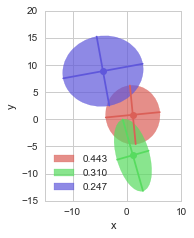

In [46]:
fig,ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm_em_result, ax=ax)

In [47]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points))
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig_em = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmQZPddJ/h5eWdl3fd9qmXZktqWfCBCaBySMfIax/Zq
3LRRjyTQuseLiDVrGUPIFhYGWj6CwTiGQfZC7+xGyIDcWB6wsWcXMJrwYION1WgELbehK+uuyqsy
KyvvzHfsH9nfX/3y5TvzqMpsv0+EQtVVL3/v9zLf++T3/HwFRVEUOHDgwMFNCtdJb8CBAwcO2gmH
5Bw4cHBTwyE5Bw4c3NRwSM6BAwc3NRySc+DAwU0Nh+QcOHBwU8MhOQcOHNzUcEjOgQMHNzUcknPg
wMFNDYfkHDhwcFPDITkHDhzc1HBIzoEDBzc1HJJz4MDBTQ2H5Bw4cHBTwyE5Bw4c3NRwSM6BAwc3
NRySc+DAwU0Nh+QcOHBwU8MhOQcOHNzUcEjOgQMHNzUcknPgwMFNDYfkHDhwcFPDITkHDhzc1HBI
zoEDBzc1HJJz4MDBTQ3PSW/AwclDURSUy2WIogi32w2v1wuXywVBEE56aw4cNA1BURTlpDfh4ORQ
KpWQTqfR19eHSqUCANjd3cXQ0BD6+vrgcrkc0nPQ1XAsuR9hSJKEQqGAeDyOUCgEURTh9XqhKAoU
RYEkSRBFEeVyGYIgwO12O6TnoOvgkNyPIBRFgSiKkCQJgiBAkiSsrq5CkiR4PB7Isox8Pg+/3w+P
5+gWIdIrlUpwuVxwu91wu93weDwO6TnoWDju6o8YZFlGpVIBfex7e3tIJpOYn5+Hz+dDuVxGJBKB
IAioVCrweDzo6elBMBhET08P3G53zXq0jiAIjOw8Hk/dcQ4cnBQcS+5HBOR+SpIEABBFEdvb25Bl
GV6vF319fSiXywgEAvB6vRgYGEAoFEKpVEI+n0c6nUY0GmWkR8THk5koilAUBaVSCbFYDBMTE/D5
fA7pOThROCT3IwBZliGKImRZhiAIyGQy2NnZwfDwMPr7+7G5uVlzvCAIUBQFgiAgEAggEAhgeHgY
iqKgWCyiUCjg4OAAkUgEXq+XER5PerlcDuVymZEeubeOpefguOGQ3E0OiqNRMiESieDw8BBzc3PM
UrMasRAEgZEZT3r5fB4HBwfY29uDz+dDT08PFEVhpAocxQEd0nNw3HBI7iaFLMuQJAmyLAMAyuUy
tra24PP5sLKywhIKzSQLeNKjc5KlJ8sytra24Pf7WTwvGAzC5arWnzuk5+C44JDcTQhZlpFIJJBO
pzE/P49UKoVIJILx8XEMDw/XEZvakiN31S5cLheL1x0eHmJqaoplapPJJIrFIvx+f417a0R62WwW
/f398Pv9Duk5aBgOyd1kIPcUqBLH9vY2CoUClpaWEAgE6o5vZ9mHy+VCIBBAT08PgCr5FgoFFAoF
7O/vo1QqIRAIMEsvEAjUkF4sFoPH44Eoio6l56BhOCR3k0Bd+1apVJDNZjE4OIiVlRVGHnqvBdpL
eECV9EKhEEKhEIAj0svn80gkEoz0yNKj5AdZlnrurc/nc2r0HOjCIbmbAOrat0QigVgsBp/Ph5mZ
GcPXapFDo+6qXahJjzowqAtDFEVEIhGEQiFm6ZklMqj31iE9BwSH5LocZL0BVZLY2dmBKIqYnJzE
4eGhpTU6pR7c7Xajt7cXvb29AIBwOIz+/n6Uy2XEYjFUKpUaS0+L9CqVCorFIiM9QRDg9Xod9/ZH
GA7JdSnU7mk2m8X29jYGBwcxPz+PXC5nibz0LJ5WEF+zawiCgJ6eHgwODgI4svTy+Tyi0ShEUWSk
19PTA7/fX0d6e3t7bA3H0vvRhENyXQi+9g0AotEoUqkUZmZm0NfXx45rlGRaQQDtIBG1pSeKIiO9
SCQCURRrylX8fj/bi56l55DezQ+H5LoIiqJgf38fXq8XgUAAlUoF29vbEAQBKysr8Hq97FirD+1x
xd/aAY/Hg76+PkbsPOkdHBxAkiSWcPH7/TUJCp70KKZHxOeQ3s0Fh+S6BNSalUqlWJxqZ2cHo6Oj
GB0drXsomyWvbiQ+LdLb3d1l/5ckqUZsgCc9WZZZAocnPY/HA4/H45BeF8MhuS6AJElM0BIAUqkU
yuUyFhYWWA1aoyAyzOVySKfTrHvhZgARFBFfpVKpsfRkWWaE19PTU2PB8aRXqVSQyWQwMTHhkF4X
wiG5DoY6uVAsFpHNZuH3+3HLLbcYZgytWnJ0zPb2Nvr7+3FwcIB8Pg+PxwNJkuo6E7oZXq8XXq8X
/f39AIBKpYJ8Po9CoYBkMglFUWosPSI9URSRz+eZeysIgmPpdREckutQ8MohAJBMJhGNRhEIBDAw
MGBaEmGF5CqVCra2tgAAy8vL7PexWIydl+9MIIuHL93oZpCk1MDAABRFqbH0kskkACAYDDIhUSpO
BmotPYf0OhsOyXUg+No3WZaxu7uLYrGIpaUl9vA1C15uKZ/Pw+v1MpdYEAT4fD4MDw+zPdDDr65X
U5dutBKtKmOxsje6Zp/PV0N6+XwemUwGpVIJa2trmpYe4JBeJ8MhuQ6C2j3N5/PY2tpCX18fa82y
6obqHacoCqLRKA4ODjA7O4ve3l7E43HDNbU6E8jNU5duUECfztUsTooceNLzer1IJpOYmJhAPp9H
LpdDIpGAy+WqKVnRIz2gWv5CXw7t+lJwoA2H5DoE6tq3eDyORCKB6elpDAwMNLSmmmTIPXW5XLjl
lltq5jfwMCNSt9tdl8XM5/M1AX1FUZDNZtngm25+qBVFYT2yPp8Pg4ODbIxjPp9HNptFLBaD2+2u
IXvegpNlGbFYDKFQCH19fTVDgagzw0F74JDcCYMym3t7e5ifn4ckSUyWfGVlhVlFBDuWHA9yT0dG
RupKTpotN/F4POjv768J6G9tbaFYLCKdTrPOBd7iOS5YdVftQhAE+P1++P1+DA0N1ZBeJpNhpMdf
Ny84oGXp0VAgh/RaC4fkThCUXKAJWEREQ0NDGB8fb6p5no4j9zSdTjM14HaDrJPR0VH4/X4W2+It
Hv7h17MoOwVWiFKL9EqlEgqFAg4PDxGNRplaMnCU0FC7t+VyGQDqhgI5pNc4OvvuuonBu6ckjbSz
s8PiZHqwY3XJsoxwOAy3212jBqy3pvr/rQAf21K7efTwGw3H6QQ08l7w8zGI9DY3N+HxeOqGAvGT
0IjMaOiQeuatQ3r24ZDcMUNL9217exuKohjGydRrmCGbzUKWZfT392t2RJwUtCwefjgOPyeCrJtm
0Cp3tdk1KOPa39/PZmDQdafTaUQiEfh8vppEhh7p7e3tYWpqqmYSWqd8vp0Ih+SOEeqpWel0Gru7
uxgeHmYzTs1gdjPLsszcU0EQMDY2ZmlvJ9XGpR6OQ3Mi8vk8ZFnG5uamrnrwcaEdcT07Q4H4SWiC
IKBQKLAuGMfSM4dDcscEvvZNURTs7u4il8thcXGRlShYgZErScNqPB4PlpeXcf36dctrqv/drAUF
NEac6jkRMzMzLHsbj8dRLpdrrJ1uKkw2IkujoUCpVAp7e3tsKBBlr+l1gOPeGsEhuTZDqzVra2sL
wWAQKysrcLvdkCTJ1lhArWPJKhwbG8PIyAhLOtjZZyc+CHrqwbymnLpGj7+O4ywobuU6PNmPjIzU
WLiKomB9fV1zKBBPeqIoOqQHh+TaCnVj/f7+PmKxGCYnJzE0NMR+byfQrz5WlmVEIhFkMpm6hn07
a7YarSIFNYw05bSa7juJvJvZC096yWQSy8vLKJVKyOfzpkOBAG3SK5VK6O3tvek7MhySawMURYEk
Sbh69SpuueUWAMDu7i7K5TKWl5eZmCPBbjaTji2VSmyWqlnDvpU16UbvJo05tbySuuleFEXs7++j
r6+PtWLZRac

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQsAAADSCAYAAABdE+UBAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztnW1wVOXZx//JLpG8LOHxAUIEFsJCqkQgL1RmWmLbaErr
2KpdcRM1Tmum1g+lY0UlakkQQ0Jbwxe0dnTKjIZRg/rBMnW0vPhMHsGxCXYDSeQlecgGEEJSCWR3
gU12z/MhnMPZzXm5z76ds7vXbyaju/e5z7kT9vz3uq/7Ov87jeM4DgRBECqk6z0AgiASAxILgiCY
ILEgCIIJEguCIJggsSAIggkSC4IgmDDrPQCCINgIBALYvHkzjh8/joyMDDQ2NmLhwoVC+4EDB/Da
a6/BbDbDbrfjoYceku3T29uL3/zmN1i0aBEAoLq6Gvfcc4/yADiCIBKCTz/9lNu4cSPHcRz373//
m3vyySeFNp/Px919993c6Ogod+3aNe4Xv/gFNzw8LNtn9+7d3N/+9jdN16fIgiAShMOHD6O8vBwA
UFxcjO7ubqGtv78fVqsVubm5AICysjJ0dHTA6XRK9unu7sapU6ewf/9+LFy4EC+88AJycnIUr5+Q
YnH48GG9h0AQAmVlZczHOp374ffPlG3PyMjA8uXLJdvcbnfQDW0ymTAxMQGz2Qy32w2LxSK0ZWdn
w+12y/ZZsWIF1q1bh9tvvx2vv/46XnvtNWzcuFFx7AkpFgDQtuUzvYcgydiYGxaLskIbBRpr5Djq
f6TpeL9/JuZZm2Tbzw6+INuWk5MDj8cjvA4EAjCbzZJtHo8HFotFtk9lZSVmzJgBAKisrMTLL7+s
OnZaDSGIBKG0tBTt7e0AAKfTicLCQqHNZrPB5XJhdHQUPp8PnZ2dKCkpke1TW1uLI0eOAAC++OIL
FBUVqV4/YSMLgkg1KisrcfDgQVRVVYHjODQ1NWHPnj3wer1wOByoq6tDbW0tOI6D3W5HXl6eZB8A
2Lx5M15++WVMmzYNs2bNYoosSCwIIkFIT0/Hli1bgt6z2WzC/1dUVKCiokK1DwAUFRXhvffe03Z9
TUcTBJGykFgQBMEEiQVBEEyQWBAEwQQlOBOIvpErmo5fMiszRiMhUhESCwMjJQ625Vamvv1HBxXF
hYSE0AqJhQER3+Ss4hCKUj9eSPx+wHQtWFBIRAg5SCwMRDREggX+3GNjY0HPE4RGIyQchBgSCwMQ
L5FQQ3xtsXCQaBCATqshXV1dqKmpAQD09vaivLwcNTU1qKmpwccff6zHkHSDvyFty626CkUo4vFo
TawSyUncI4s333wTf//735GZOflt1dPTg1/96ld4/PHH4z0U3RELhVGxLbdSlEEA0EEsrFYrduzY
geeeew5AeCYcyUAiCAUPP0ZeNEgwIuM/V0/qPYSwiLtYrF27FmfOnBFeh2PCAUz6GxgVtbF94538
b75tFsbGxuIwInm0XH/Oov/Cuf4RHB9y45asGA5KBiP/m2thAD+UbZsbv2FoRvcEZzgmHAAMaYQC
qJu09I1cQWGxMaKJ0NUQFizFFvQfHcTQtfhOSYxqfpNK6F7uHY4JR6KSLIlCSnymJrpHFuGYcCQi
iZSjYIFPfBKpgy5iMX/+fOzevRtAeCYciUayCQWPbbkVfUcHKeGZIug+DUl2klUoeGzLrTQdSRFI
LGJIsgsFDwlGakBiESNSRSjEkGAkNyQWMSAVhYJWSJIfEosowxdcpZJQ8JBgJDe6L50mE0aLKHpG
RxXb/X4/TNePKZopv6WeFgTBuL6sSislyQOJRZTghSLfNku3MUiJg61QvoCYr+DsP3E+qG80hEP8
ABoJRnJAYhFFbMutujzrIb7RlcRBDnEfXjhIMIhQKGcRBfpGrugy9egZHRWEwlY4NyyhCIU/h/jc
EZ2P8hhRIxAIoL6+Hg6HAzU1NXC5XEHtBw4cgN1uh8PhEIoe1frs2bMHDoeD6fokFhGix00QC5EQ
Iz4nCYZx2LdvH3w+H9ra2rBhwwZs27ZNaBsfH0dzczN27tyJ1tZWtLW1YWRkRLFPb28vPvjgA3Ac
x3R9EosoEM+oIpYiEQoJRmxweQdlf5Q4fPgwysvLAQDFxcXo7u4W2vr7+2G1WpGbm4uMjAyUlZWh
o6NDts/Fixexfft2vPDCC8zjppxFBMTzgx9pXiJcbIVzo5bHoBzGJJcC3wurn9vtDjKGMplMmJiY
gNlshtvtDrIbyM7Ohtvtluzj8/nw4osv4vnnn8dNN93EfH2KLCIkHlFFPKMJKfjrRiOPQRFG+OTk
5MDj8QivA4EAzGazZJvH44HFYpHsc+zYMbhcLmzevBlPP/00+vr6sHXrVtXrk1iESbw+7GKh0Jto
TUuMUoeSaJSWlqK9vR0A4HQ6UVhYKLTZbDa4XC6Mjo7C5/Ohs7MTJSUlkn1WrFiBf/zjH2htbcX2
7duxZMkSvPjii6rX12Ua0tXVhVdeeQWtra1wuVyoq6tDWloali5dioaGBqSnJ4aGxfpDbySh4InW
tIQeb9dOZWUlDh48iKqqKnAch6amJuzZswderxcOhwN1dXWora0Fx3Gw2+3Iy8uT7BMuurt7Nzc3
46mnnsLq1atRX1+P/fv3o7KyMt7D0kQ8ogojCgVPNPMYqZ6/0EJ6ejq2bNkS9J7NZhP+v6KiAhUV
Fap9xIi9ZdTQ3d27p6cHd9xxBwDgzjvvxMGDB5nEQk/zVr9f2Ww30sKsUz4fACB//oyoFHn1+b1B
r5eYbrjthnv+OfnZOHfmMo785z8oyMgI7xwaDYCTxbA3UdHd3ZvjOKSlpQGYzOCyfnj1Mm/tG7kC
kwmyRrfhmOCK6RkdhclkiiiiODI2EvTaZDJhacEc4fXJUxcAXH82xGQCAKywaC9Tt9w2WSo+6PeH
HWHwBsAWi3J0QYa9+qP70qk4P+HxeASnbyMTq1xFpFMPXiTEwiAF384L28lTF4S+WkUjGlMSyl8k
BrpnEpctW4Yvv/wSANDe3o5Vq1bpPCJ5YpmriEQojoyN4MjYCJYWzFEVCin4fksL5gjn0kK0Vklo
OdXY6C4WGzduxI4dO+BwODA+Po61a9fqPSRFYhFVRCoUgHo0wQp/Hq2iEalg0HKq8dHd3bugoAC7
du3SYxiaiPW3nhGEgoc/Hz89YZ2aRGNKQqsjxkX3yCKRiFVUoVUoIp12sCKOMliJJMKg6MLYkFjo
SDg3VKyiCTniLRgA5S6MCokFA7H0qwhn+hEvoRBfT2vyM1zBoOjCuJBY6ES4049whKLLOxz0Ey5a
o4xoPuJO6I/udRZGxyghsZZpgJQg3Dp/NgDg2JkbguHHBEzeq1iZNZv53EsL5mhKfPJJTy0ke93F
8cvnZNt+bOA70sBDMw7RDo21ftNqyVPwQsCLQyji9/mirK4zN8SFRTjCEYyeE+ej5iCe6JgDy/Ue
QljQNEQnWKcgrEIhnmLICYUct86fLfRhnaqI8xisaBVJo0R1xCQkFgrE4sMazvydRSiA4Js+HEJF
g3VsLIKhNT9DiU7jQWKhQiw+tFqjCiXCjSaU4EVDS5TBKhiU7ExcSCwMjlJUEQuhEKMlytA6JSES
DxKLOKLlW1VtmTTWQsGjNcpQEwyt0QXlLYwDrYbEmWg6X7EIRZdPfpnOb/bD5HNjZUY+07X4ZVe5
FROtqyRq8G7ghDEgsTAgrFGFEmKRuG2u9M3tHhvDac/VoGOVhEOLYBDJh2HE4oEHHhD2N5g/fz6a
m5t1HlF0iXZiTymq4G9+OZEQIz7m6/PDQl850WARDACK0QXVXSQmhhCLa9eugeM4tLa26j2UmBKN
KYhaVKFFKELh+6iJhppgUHSRnBgiwXns2DFcuXIFjz/+OB577DE4nU69h6QbLCsKclFFJEIh5ra5
s4VzyOU8WFZ

## Goodness-of-fit Statistics

In [48]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points))
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.989  0.020      0.047  9.039823e-09      0.021       0.149

# 5. GMM by Optimization

In [49]:
sample = SPEED_SET
points = FITTING_RANGE
max_speed = df.speed.max()
print(FIT_METHOD)

square_error


In [50]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
#         {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#         {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-fit_limit, fit_limit),(-fit_limit, fit_limit),
         (0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*(len(x0)//6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points, FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -19.81678460960217
     jac: array([  2.28867984e+00,   4.76837158e-07,  -9.53674316e-07,
         2.38418579e-07,  -9.53674316e-07,  -2.62260437e-06,
         2.28869629e+00,   1.43051147e-06,   2.38418579e-07,
        -9.53674316e-07,  -9.53674316e-07,   1.19209290e-06,
         2.28869271e+00,   1.90734863e-06,   2.38418579e-07,
        -2.38418579e-07,  -4.76837158e-07,  -1.90734863e-06,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1505
     nit: 74
    njev: 74
  status: 0
 success: True
       x: array([ 0.59642881, -0.68767195,  4.10855018,  7.12403142,  7.76281384,
       -0.21176273,  0.20918955,  0.35966611, -1.6255617 ,  3.08372483,
        4.92257115,  0.11793038,  0.19438163,  1.47643706, -7.65141938,
        3.42595956,  6.56605546, -0.41849048])

## 5.1 GMM Result

In [51]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)
pretty_print_gmm(gmm)

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.596  -0.688   4.109  7.124  7.763  -0.212
2  0.209   0.360  -1.626  3.084  4.923   0.118
3  0.194   1.476  -7.651  3.426  6.566  -0.418

GMM Plot Result
0.596428812701 [[-0.68767195  4.10855018]] [ 6.54729843  8.25505818] -146.048692848
0.20918955393 [[ 0.35966611 -1.6255617 ]] [ 3.04873907  4.94431548] 173.165778647
0.194381633369 [[ 1.47643706 -7.65141938]] [ 3.02148954  6.76172198] -164.51651756


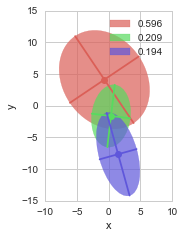

In [52]:
fig_gmm, ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm,ax=ax)

## 5.2 Goodness-of-fit statistics

In [53]:
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.007      0.010  2.475596e-09      0.011       0.078

In [54]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y')
fig_gmm = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y')
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmQI9d9JvhlAkicdd9VXVVdhSYtmzpI9siyraW8brsd
Wo68GrmtJvmHdy23LXlmR7ZGtCxaCskdVPOQZlZ2hEVzLHs5MUuFQy3TO3bQ0sbaLXJXXo5jTTbd
1jRlUmTdJ44CCoU7r7d/oN6rzEQmkAkkqoBifhEdXQW8fJkFID98v5sjhBB48ODBwykFf9IX4MGD
Bw+dhEdyHjx4ONXwSM6DBw+nGh7JefDg4VTDIzkPHjycangk58GDh1MNj+Q8ePBwquGRnAcPHk41
PJLz4MHDqYZHch48eDjV8EjOgwcPpxoeyXnw4OFUwyM5Dx48nGp4JOfBg4dTDY/kPHjwcKrhkZwH
Dx5ONTyS8+DBw6mGR3IePHg41fBIzoMHD6caHsl58ODhVMMjOQ8ePJxqeCTnwYOHUw2P5Dx48HCq
4ZGcBw8eTjU8kvPgwcOphv+kL8DDyYMQAlEUIcsyfD4fAoEAeJ4Hx3EnfWkePLQNjhBCTvoiPJwc
qtUqcrkc+vr6IEkSAGB7extDQ0Po6+sDz/Me6XnoaXhK7m0MRVFQLpeRSqUQjUYhyzICgQAIISCE
QFEUyLIMURTBcRx8Pp9Heh56Dh7JvQ1BCIEsy1AUBRzHQVEULC0tQVEU+P1+qKqKUqmEYDAIv//o
I0JJr1qtgud5+Hw++Hw++P1+j/Q8dC08c/VtBlVVIUkS6Nu+s7ODTCaDubk5CIIAURSxu7sLjuMg
SRL8fj8ikQjC4TAikQh8Pp9uP7oPx3GM7Px+f906Dx5OCp6Se5uAmp+KogAAZFnG5uYmVFVFIBBA
X18fRFFEKBRCIBDAwMAAotEoqtUqSqUScrkcEokEIz1KfFoyk2UZhBBUq1Ukk0lMTExAEASP9Dyc
KDySextAVVXIsgxVVcFxHPL5PLa2tjA8PIz+/n6sr6/r1nMcB0IIOI5DKBRCKBTC8PAwCCGoVCoo
l8vY39/H7u4uAoEAIzwt6RWLRYiiyEiPmree0vNw3PBI7pSD+tFoMGF3dxcHBweYnZ1lSs2ux4Lj
OEZmWtIrlUrY39/Hzs4OBEFAJBIBIYSRKnDkB/RIz8NxwyO5UwpVVaEoClRVBQCIooiNjQ0IgoB4
PM4CCu0EC7SkR89JlZ6qqtjY2EAwGGT+vHA4DJ6v5Z97pOfhuOCR3CmEqqpIp9PI5XKYm5tDNpvF
7u4uxsfHMTw8XEdsRiVHzVWn4Hme+esODg4wNTXFIrWZTAaVSgXBYFBn3jYivUKhgP7+fgSDQY/0
PLQMj+ROGah5CtSIY3NzE+VyGQsLCwiFQnXrO5n2wfM8QqEQIpEIgBr5lstllMtl7O3toVqtIhQK
MaUXCoV0pJdMJuH3+yHLsqf0PLQMj+ROCYy5b5IkoVAoYHBwEPF4nJGH1bFAZwkPqJFeNBpFNBoF
cER6pVIJ6XSakR5VejT4QZWllXkrCIKXo+fBEh7JnQIYc9/S6TSSySQEQcDMzEzDY83IoVVz1SmM
pEcrMGgVhizL2N3dRTQaZUqvWSCD1t56pOeBwiO5HgdVb0CNJLa2tiDLMiYnJ3FwcGBrj27JB/f5
fIjFYojFYgCA5eVl9Pf3QxRFJJNJSJKkU3pmpCdJEiqVCiM9juMQCAQ88/ZtDI/kehRG87RQKGBz
cxODg4OYm5tDsVi0RV5WiscN4mt3D47jEIlEMDg4COBI6ZVKJSQSCciyzEgvEokgGAzWkd7Ozg7b
w1N6b094JNeD0Oa+AUAikUA2m8XMzAz6+vrYulZJxg0C6ASJGJWeLMuM9HZ3dyHLsi5dJRgMsmux
Unoe6Z1+eCTXQyCEYG9vD4FAAKFQCJIkYXNzExzHIR6PIxAIsLV2b9rj8r91An6/H319fYzYtaS3
v78PRVFYwCUYDOoCFFrSoz49Snwe6Z0ueCTXI6ClWdlslvmptra2MDo6itHR0bqbsl3y6kXiMyO9
7e1t9r+iKLpmA1rSU1WVBXC0pOf3++H3+z3S62F4JNcDUBSFNbQEgGw2C1EUMT8/z3LQWoW2TlX7
2GkAJShKfJIk6ZSeqqqM8CKRiE7BaUlPkiTk83lMTEx4pNeD8Eiui2EMLlQqFRQKBQSDQZw7d65h
xLCXzdBOIRAIIBAIoL+/HwAgSRJKpRLK5TIymQwIITqlR0lPlmWUSiVm3nIc5ym9HoJHcl0KbecQ
AMhkMkgkEgiFQhgYGGiaEmGX5LQ+KqfH9jpoS6mBgQEQQnRKL5PJAADC4TBrJKpVvFql55Fed8Mj
uS6ENvdNVVVsb2+jUqlgYWGB3XxvB7iVxmKHcDiOgyAIEARBR3qlUgn5fB7VahUrKyumSg/wSK+b
4ZFcF8FonpZKJWxsbKCvr4+VZjlRaE5aKHVCubmx50mRg5b0AoEAMpkMJiYmUCqVUCwWkU6nwfO8
LmXFivSAWvoLTWbW5vN56Dw8kusSGHPfUqkU0uk0pqenMTAw0NKe7eTJuZHIe1pACGE1soIgYHBw
kI1xLJVKKBQKSCaT8Pl8ukCGVsGpqopkMoloNIq+vj7dUCBameGhM/BI7oRBCEGxWMTOzg7m5uag
KAprSx6PxyEIgm69U1+bHZxmH5xdc9UpOI5DMBhEMBjE0NCQjvTy+TwjPW2reG3DATOlR4cCeaTn
LjySO0HQ4AKdgEXbkg8NDWF8fLyt4vnTTFzHDTtEaUZ61WoV5XIZBwcHSCQSrFsycBTQMJq3oigC
QN1QII/0WodHcicErXlKWyNtbW3hzJkzrGzJDE7Iy6lPzvi/hxpaeS208zEo6a2vr8Pv99cNBdJO
QqNkRocOGWfeeqTnHB7JHTPM+r5tbm6CEIJz587p5pw22qMZvJugBrfM1Xb3oBHX/v5+NgODtorP
5XLY3d2FIAi6QIYV6e3s7GBqako3Cc17v63hkdwxwjg1K5fLYXt7G8PDw2zGaTN0qibVU27W6IRf
z8lQIO0kNI7jUC6XWRWMp/SawyO5Y4I2940Qgu3tbRSLRZw9e5alKNhBJ0xJs7pX6jtqBx5x6tGI
LBsNBcpms9jZ2WFDgWhiMj0O8MzbRvBIrsMwK83a2NhAOBxGPB6Hz+eDoiiu57Q5JUPq9NZ2MjkN
OM6EYjf30Q4FGhkZYaRXKpVACMHq6qrpUCAt6cmy7JEePJLrKIyF9Xt7e0gmk5icnMTQ0BB7vBOJ
u05JbmNjg6kBmspAp2u1ckO4RQpuoFtu6HbIUkt6mUwGi4uLqFarKJVKTYcCAeakV61WEYvFTn1F
hkdyHQAhBIqi4LXXXsO5c+cAANvb2xBFEYuLi6yZI8VJ+s8ODg4gyzIGBwcxPDwMRVGQSqVQqVRY
I0p6cxlLmd4u6FSuXSug772W9ADroUCNSG91dRXz8/MsIZkmJ2sV4WmAR3Iuw1hYXywWsbu7i/7+
fpw5c6bp1Cw7+Vh2oC28NzuGEIJEIoFcLge/34+hoSH2DR8MBsHzPMbHx02L1rUJrp02b9u92brJ
L+gGWWoTirVoNAktlUpBFEVdq/hQKARCCGv0YKb0qKLvddLzSM5FGEuzaHH9zMwMa+9jBvqhtUty
TlWfcU9JkrCxsQGe5xGPx7G8vFy3J/1d255IW7SuLWXSKr1uHBjjFrG0CzdJrhkaTUJLJpMQRRGE
EGSz2bpJaHS9LMt1reJ7kfQ8knMB1DyVZZn1H6O5b3Nzcw2Te437NINT/50RtKpiZGSEdRQ2i65a
7Wes36R+IZrgGggEEIlEoCiKKxHa04TjJDkjzOZjLC8vQ1GUuqFA2kloxkBGtVoFx3F1FRndDI/k
2oQx942SyPD

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQsAAADSCAYAAABdE+UBAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztnW1wVOXZx//JLpG8LOHxAUIEFsJCqkQgL1RmWmLbaErr
2KpdcRM1Tmum1g+lY0UlakkQQ0Jbwxe0dnTKjIZRg/rBMnW0vPhMHsGxCXYDSeQlecgGEEJSCWR3
gU12z/MhnMPZzXm5z76ds7vXbyaju/e5z7kT9vz3uq/7Ov87jeM4DgRBECqk6z0AgiASAxILgiCY
ILEgCIIJEguCIJggsSAIggkSC4IgmDDrPQCCINgIBALYvHkzjh8/joyMDDQ2NmLhwoVC+4EDB/Da
a6/BbDbDbrfjoYceku3T29uL3/zmN1i0aBEAoLq6Gvfcc4/yADiCIBKCTz/9lNu4cSPHcRz373//
m3vyySeFNp/Px919993c6Ogod+3aNe4Xv/gFNzw8LNtn9+7d3N/+9jdN16fIgiAShMOHD6O8vBwA
UFxcjO7ubqGtv78fVqsVubm5AICysjJ0dHTA6XRK9unu7sapU6ewf/9+LFy4EC+88AJycnIUr5+Q
YnH48GG9h0AQAmVlZczHOp374ffPlG3PyMjA8uXLJdvcbnfQDW0ymTAxMQGz2Qy32w2LxSK0ZWdn
w+12y/ZZsWIF1q1bh9tvvx2vv/46XnvtNWzcuFFx7AkpFgDQtuUzvYcgydiYGxaLskIbBRpr5Djq
f6TpeL9/JuZZm2Tbzw6+INuWk5MDj8cjvA4EAjCbzZJtHo8HFotFtk9lZSVmzJgBAKisrMTLL7+s
OnZaDSGIBKG0tBTt7e0AAKfTicLCQqHNZrPB5XJhdHQUPp8PnZ2dKCkpke1TW1uLI0eOAAC++OIL
FBUVqV4/YSMLgkg1KisrcfDgQVRVVYHjODQ1NWHPnj3wer1wOByoq6tDbW0tOI6D3W5HXl6eZB8A
2Lx5M15++WVMmzYNs2bNYoosSCwIIkFIT0/Hli1bgt6z2WzC/1dUVKCiokK1DwAUFRXhvffe03Z9
TUcTBJGykFgQBMEEiQVBEEyQWBAEwQQlOBOIvpErmo5fMiszRiMhUhESCwMjJQ625Vamvv1HBxXF
hYSE0AqJhQER3+Ss4hCKUj9eSPx+wHQtWFBIRAg5SCwMRDREggX+3GNjY0HPE4RGIyQchBgSCwMQ
L5FQQ3xtsXCQaBCATqshXV1dqKmpAQD09vaivLwcNTU1qKmpwccff6zHkHSDvyFty626CkUo4vFo
TawSyUncI4s333wTf//735GZOflt1dPTg1/96ld4/PHH4z0U3RELhVGxLbdSlEEA0EEsrFYrduzY
geeeew5AeCYcyUAiCAUPP0ZeNEgwIuM/V0/qPYSwiLtYrF27FmfOnBFeh2PCAUz6GxgVtbF94538
b75tFsbGxuIwInm0XH/Oov/Cuf4RHB9y45asGA5KBiP/m2thAD+UbZsbv2FoRvcEZzgmHAAMaYQC
qJu09I1cQWGxMaKJ0NUQFizFFvQfHcTQtfhOSYxqfpNK6F7uHY4JR6KSLIlCSnymJrpHFuGYcCQi
iZSjYIFPfBKpgy5iMX/+fOzevRtAeCYciUayCQWPbbkVfUcHKeGZIug+DUl2klUoeGzLrTQdSRFI
LGJIsgsFDwlGakBiESNSRSjEkGAkNyQWMSAVhYJWSJIfEosowxdcpZJQ8JBgJDe6L50mE0aLKHpG
RxXb/X4/TNePKZopv6WeFgTBuL6sSislyQOJRZTghSLfNku3MUiJg61QvoCYr+DsP3E+qG80hEP8
ABoJRnJAYhFFbMutujzrIb7RlcRBDnEfXjhIMIhQKGcRBfpGrugy9egZHRWEwlY4NyyhCIU/h/jc
EZ2P8hhRIxAIoL6+Hg6HAzU1NXC5XEHtBw4cgN1uh8PhEIoe1frs2bMHDoeD6fokFhGix00QC5EQ
Iz4nCYZx2LdvH3w+H9ra2rBhwwZs27ZNaBsfH0dzczN27tyJ1tZWtLW1YWRkRLFPb28vPvjgA3Ac
x3R9EosoEM+oIpYiEQoJRmxweQdlf5Q4fPgwysvLAQDFxcXo7u4W2vr7+2G1WpGbm4uMjAyUlZWh
o6NDts/Fixexfft2vPDCC8zjppxFBMTzgx9pXiJcbIVzo5bHoBzGJJcC3wurn9vtDjKGMplMmJiY
gNlshtvtDrIbyM7Ohtvtluzj8/nw4osv4vnnn8dNN93EfH2KLCIkHlFFPKMJKfjrRiOPQRFG+OTk
5MDj8QivA4EAzGazZJvH44HFYpHsc+zYMbhcLmzevBlPP/00+vr6sHXrVtXrk1iESbw+7GKh0Jto
TUuMUoeSaJSWlqK9vR0A4HQ6UVhYKLTZbDa4XC6Mjo7C5/Ohs7MTJSUlkn1WrFiBf/zjH2htbcX2
7duxZMkSvPjii6rX12Ua0tXVhVdeeQWtra1wuVyoq6tDWloali5dioaGBqSnJ4aGxfpDbySh4InW
tIQeb9dOZWUlDh48iKqqKnAch6amJuzZswderxcOhwN1dXWora0Fx3Gw2+3Iy8uT7BMuurt7Nzc3
46mnnsLq1atRX1+P/fv3o7KyMt7D0kQ8ogojCgVPNPMYqZ6/0EJ6ejq2bNkS9J7NZhP+v6KiAhUV
Fap9xIi9ZdTQ3d27p6cHd9xxBwDgzjvvxMGDB5nEQk/zVr9f2Ww30sKsUz4fACB//oyoFHn1+b1B
r5eYbrjthnv+OfnZOHfmMo785z8oyMgI7xwaDYCTxbA3UdHd3ZvjOKSlpQGYzOCyfnj1Mm/tG7kC
kwmyRrfhmOCK6RkdhclkiiiiODI2EvTaZDJhacEc4fXJUxcAXH82xGQCAKywaC9Tt9w2WSo+6PeH
HWHwBsAWi3J0QYa9+qP70qk4P+HxeASnbyMTq1xFpFMPXiTEwiAF384L28lTF4S+WkUjGlMSyl8k
BrpnEpctW4Yvv/wSANDe3o5Vq1bpPCJ5YpmriEQojoyN4MjYCJYWzFEVCin4fksL5gjn0kK0Vklo
OdXY6C4WGzduxI4dO+BwODA+Po61a9fqPSRFYhFVRCoUgHo0wQp/Hq2iEalg0HKq8dHd3bugoAC7
du3SYxiaiPW3nhGEgoc/Hz89YZ2aRGNKQqsjxkX3yCKRiFVUoVUoIp12sCKOMliJJMKg6MLYkFjo
SDg3VKyiCTniLRgA5S6MCokFA7H0qwhn+hEvoRBfT2vyM1zBoOjCuJBY6ES4049whKLLOxz0Ey5a
o4xoPuJO6I/udRZGxyghsZZpgJQg3Dp/NgDg2JkbguHHBEzeq1iZNZv53EsL5mhKfPJJTy0ke93F
8cvnZNt+bOA70sBDMw7RDo21ftNqyVPwQsCLQyji9/mirK4zN8SFRTjCEYyeE+ej5iCe6JgDy/Ue
QljQNEQnWKcgrEIhnmLICYUct86fLfRhnaqI8xisaBVJo0R1xCQkFgrE4sMazvydRSiA4Js+HEJF
g3VsLIKhNT9DiU7jQWKhQiw+tFqjCiXCjSaU4EVDS5TBKhiU7ExcSCwMjlJUEQuhEKMlytA6JSES
DxKLOKLlW1VtmTTWQsGjNcpQEwyt0QXlLYwDrYbEmWg6X7EIRZdPfpnOb/bD5HNjZUY+07X4ZVe5
FROtqyRq8G7ghDEgsTAgrFGFEmKRuG2u9M3tHhvDac/VoGOVhEOLYBDJh2HE4oEHHhD2N5g/fz6a
m5t1HlF0iXZiTymq4G9+OZEQIz7m6/PDQl850WARDACK0QXVXSQmhhCLa9eugeM4tLa26j2UmBKN
KYhaVKFFKELh+6iJhppgUHSRnBgiwXns2DFcuXIFjz/+OB577DE4nU69h6QbLCsKclFFJEIh5ra5
s4VzyOU8WFZ

In [55]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log


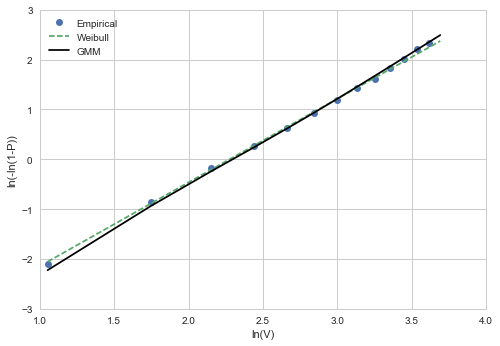

In [56]:
x = linspace(0, max_speed, 15)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plot(log(x), log(-log(1-y)),'o', label = 'Empirical')

# 2. Weibull distribution
weibull_params = sp.stats.weibull_min.fit(df.speed, loc=0)
y_cdf_weibull = sp.stats.weibull_min.cdf(x, *weibull_params)
plot(log(x), log(-log(1-y_cdf_weibull)),'--', label = 'Weibull')

# 3. GMM distribution
y_ = [integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x]
y = array(list(zip(*y_))[0])
plot(log(x), log(-log(1-y)),'-', color='black', label = 'GMM')

plt_configure(xlabel='ln(V)',ylabel='ln(-ln(1-P))',legend={'loc':'best'})

Speed Distribution Comparison


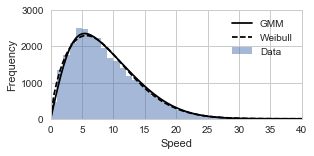

In [57]:
# Calculate Speed Distribution
# 1. GMM Model
x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[x_-0.01, x_+0.01],[0, 2*pi]]) for x_ in x]
y = array(list(zip(*y_))[0])*len(df.speed)/0.02
plot(x, y,'-', color='black', label='GMM')

# 2. Observation
df['speed'].hist(bins=arange(0, df.speed.max()), alpha=0.5, label='Data')

# 3. Weibull
y_weibul = sp.stats.weibull_min.pdf(x, *weibull_params)* len(df.speed)
plot(x, y_weibul, '--', color='black', label='Weibull')   

title='Speed Distribution Comparison'
plt_configure(xlabel='Speed',ylabel='Frequency',legend=True, figsize=(4.5, 2))
plt.gca().set_ylim(bottom = 0)
plt.locator_params(axis='y', nbins=5)
print(title)

Direction Distribution Comparison


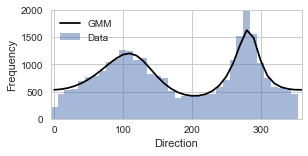

In [58]:
# Calculate Angle Distribution
x = linspace(0,2*pi, num=36+1)
y_ =[integrate.nquad(f, [[0, inf],[x_-pi/36, x_+pi/36]]) for x_ in x]
y = array(list(zip(*y_))[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5, label='Data')
plot(x/pi*180, y,'-', color='black', label='GMM')
title='Direction Distribution Comparison'
plt_configure(xlabel='Direction',ylabel='Frequency', 
              legend={'loc': 'best'} ,tight='xtight',figsize = (4.5,2))
dir_fig = plt.gcf()
print(title)

In [64]:
# %%time
incre = max(SECTOR_LENGTH, 10)
density_collection=Parallel(n_jobs=-1)(delayed(direction_compare)(gmm, df, angle, incre) 
                                        for angle in arange(0, 360, incre))  
# This R square is computed as in paper 
# Comparison of bivariate distribution constructionapproaches for analysing wind speed anddirection data
# http://onlinelibrary.wiley.com/doi/10.1002/we.400/full
print(true_R_square(density_collection))

0.921568681131


## 5.3 Sectoral Comaprison

In [65]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    curve_collection = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_angles(df, start, end, incre)
    plot_range = [0, max_speed, 0, max_count*1.05]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        data_size = len(sub_df.speed)
        direction_prob = integrate.nquad(f, [[0, inf],
                                             [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        weibull_params = sp.stats.weibull_min.fit(sub_df.speed, loc=0)
        
        fig = plt.figure(figsize=(13,1.3))
        x = linspace(0, sub_max_speed, 20)
        # 1. Frequency Comparison
        ax1 = fig.add_subplot(1,3,1)        
        # 1.1. Data Histogram
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5, label='Data')             
        # 1.2. Model Distribution
        y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], 
                                     [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                                 for x_ in x]
        y_gmm = array(list(zip(*y_gmm_))[0])/direction_prob[0]/0.02
        plot(x, y_gmm*data_size,'-', color='black', label='GMM')
        # 1.3 Weibull Distribution
        y_weibull = sp.stats.weibull_min.pdf(x, *weibull_params)
        plot(x, y_weibull*data_size, '--', color='black',label='Weibull')   
        plt_configure(xlabel = "V", ylabel='Frequency', legend=True)
        plt.axis(plot_range)
        
        # 2. CDF Comaprison
        ax2 = fig.add_subplot(1,3,2)
        # 2.1. Empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_ecdf = ecdf(x)
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_cdf_gmm = array(list(zip(*y_))[0])/direction_prob[0]
        # 2.3 Weibull
        y_cdf_weibull = sp.stats.weibull_min.cdf(x, *weibull_params)      
        plot(x, y_ecdf,'o', alpha=0.8, label='Data')
        plot(x, y_cdf_gmm,'-', color='black',label='GMM')
        plot(x, y_cdf_weibull,'--', color='black',label='Weibull')
        plt.gca().set_xlim(right = max_speed)
        plt_configure(xlabel = "V", ylabel='P', legend=True)
        
        # 3. Weibull Comparison
        ax3 = fig.add_subplot(1,3,3)
        plot(log(x), log(-log(1-y_ecdf)),'o', alpha=0.8, label='Data')
        plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black', label='GMM')
        plot(log(x), log(-log(1-y_cdf_weibull)),'--',color='black',label='Weibull')
        plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
        plt.gca().set_xlim(right = log(max_speed+1))
        
        print('%s (%s - %s) degree' % (angle, start_angle, end_angle)     )

        bins = arange(0, sub_df.speed.max()+1)
        density, _ = np.histogram(sub_df['speed'],bins=bins, normed=True)
        density_expected_ =[integrate.nquad(f, [[x_, x_+1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                    for x_ in bins[:-1]]
        density_expected_gmm = array(list(zip(*density_expected_ ))[0])/direction_prob[0]
        R_square_gmm = sector_r_square(density, density_expected_gmm)
        
        density_expected_weibull = sp.stats.weibull_min.cdf(bins[1:], *weibull_params) - sp.stats.weibull_min.cdf(bins[:-1], *weibull_params) 
        R_square_weibull = sector_r_square(density, density_expected_weibull)

        diff, diff_weibull= np.abs(y_ecdf - y_cdf_gmm), np.abs(y_ecdf - y_cdf_weibull)
        max_diff_array.append([len(sub_df), angle, diff.max(), x[diff.argmax()], 
                               diff_weibull.max(), x[diff_weibull.argmax()], R_square_gmm, R_square_weibull])
        curves = {'angle': angle, 'data_size': data_size, 'weight': direction_prob[0], 
                  'x': x, 'gmm_pdf': y_gmm, 'gmm_cdf': y_cdf_gmm,
                  'weibull_pdf': y_weibull, 'weibull_cdf': y_cdf_weibull, 'ecdf': y_ecdf}
        curve_collection.append(curves)
        
        plt.show()
        print('data size:', len(sub_df), 'weight', len(sub_df)/len(df))
        print('GMM', 'Weibull')
        print('R square', R_square_gmm,  R_square_weibull)
        print('max diff:', diff.max(), diff_weibull.max(), 'speed value:', x[diff.argmax()], 'y gmm', y_cdf_gmm[diff.argmax()])
        print(' ')
    return max_diff_array, curve_collection

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:60: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:61: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:62: RuntimeWarning: divide by zero encountered in log


5.0 (-5.0 - 15.0) degree


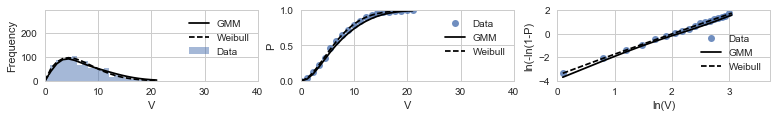

data size: 914 weight 0.031755958585226875
GMM Weibull
R square 0.925809055877 0.946828985231
max diff: 0.0667437764398 0.0170300692055 speed value: 12.1463157895 y gmm 0.841352503648
 
25.0 (15.0 - 35.0) degree


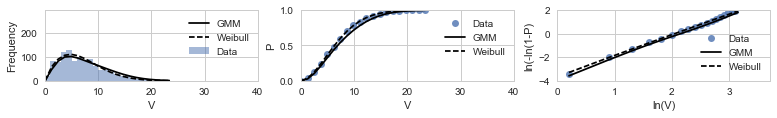

data size: 1072 weight 0.03724550066013481
GMM Weibull
R square 0.924009856226 0.947748079206
max diff: 0.0709893554131 0.0167756556678 speed value: 9.83157894737 y gmm 0.71352556996
 
45.0 (35.0 - 55.0) degree


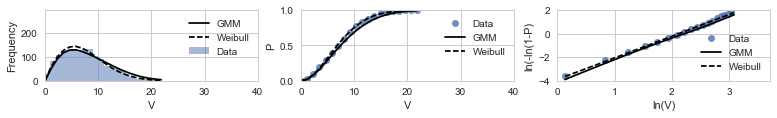

data size: 1465 weight 0.05089986797303871
GMM Weibull
R square 0.9530539109 0.971778298439
max diff: 0.064492769928 0.016982867749 speed value: 10.3405263158 y gmm 0.708886069662
 
65.0 (55.0 - 75.0) degree


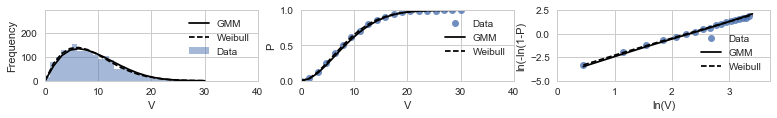

data size: 1668 weight 0.0579528872211799
GMM Weibull
R square 0.972633159744 0.980837793963
max diff: 0.0390341602323 0.0157457267295 speed value: 6.32 y gmm 0.348855528017
 
85.0 (75.0 - 95.0) degree


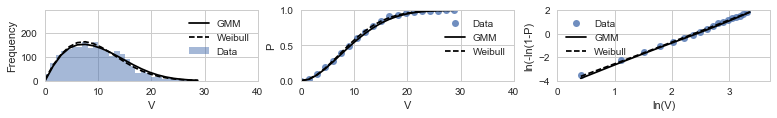

data size: 2145 weight 0.07452574525745258
GMM Weibull
R square 0.962568637549 0.957378142662
max diff: 0.0384091576322 0.0175693655393 speed value: 16.6273684211 y gmm 0.872080352857
 
105.0 (95.0 - 115.0) degree


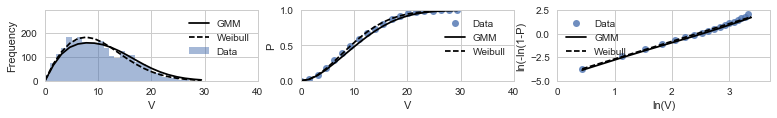

data size: 2514 weight 0.0873462580779654
GMM Weibull
R square 0.936948889879 0.946309582059
max diff: 0.0607085322816 0.0330216819595 speed value: 10.8278947368 y gmm 0.533961316565
 
125.0 (115.0 - 135.0) degree


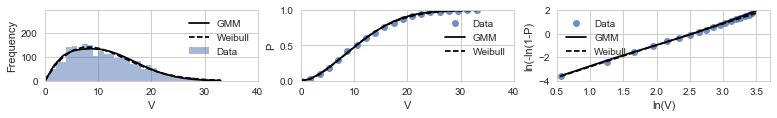

data size: 2204 weight 0.07657563755124731
GMM Weibull
R square 0.943216186292 0.949879890022
max diff: 0.0238433406932 0.0209551116837 speed value: 17.3842105263 y gmm 0.840993975902
 
145.0 (135.0 - 155.0) degree


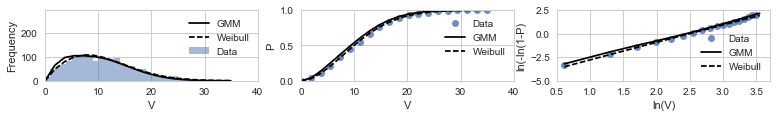

data size: 1606 weight 0.055798763115836286
GMM Weibull
R square 0.948845507037 0.969622970397
max diff: 0.0482434395769 0.0161699391367 speed value: 11.0305263158 y gmm 0.603037960125
 
165.0 (155.0 - 175.0) degree


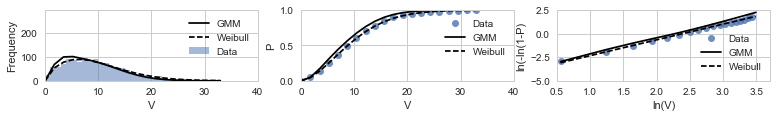

data size: 1264 weight 0.04391633659926343
GMM Weibull
R square 0.907873274331 0.972210800066
max diff: 0.0794699828173 0.0144341783333 speed value: 6.94105263158 y gmm 0.44339403345
 
185.0 (175.0 - 195.0) degree


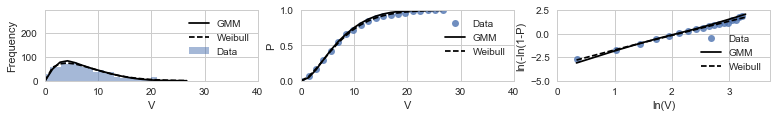

data size: 813 weight 0.02824682092974776
GMM Weibull
R square 0.951617066067 0.964995923251
max diff: 0.0299924228269 0.0165546215417 speed value: 16.8252631579 y gmm 0.96603178322
 
205.0 (195.0 - 215.0) degree


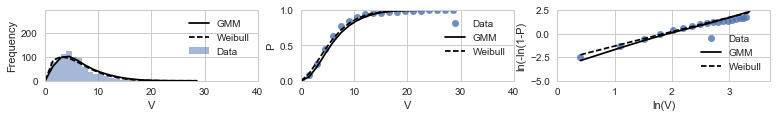

data size: 854 weight 0.029671322354249182
GMM Weibull
R square 0.948868018227 0.939184278499
max diff: 0.092535876058 0.0526977062306 speed value: 7.51315789474 y gmm 0.680297847595
 
225.0 (215.0 - 235.0) degree


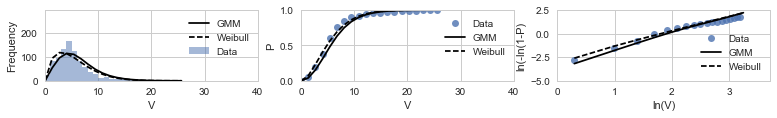

data size: 913 weight 0.031721214648043915
GMM Weibull
R square 0.884669609016 0.894831941443
max diff: 0.130031763243 0.063176305952 speed value: 5.4 y gmm 0.481140197327
 
245.0 (235.0 - 255.0) degree


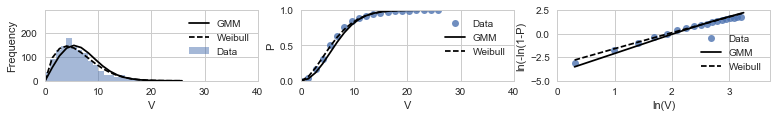

data size: 1289 weight 0.044784935028837465
GMM Weibull
R square 0.911643246175 0.9688891765
max diff: 0.105966811766 0.0278839589531 speed value: 5.42315789474 y gmm 0.394421085829
 
265.0 (255.0 - 275.0) degree


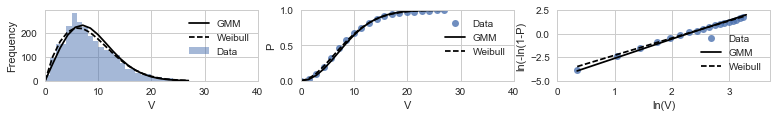

data size: 2590 weight 0.08998679730387048
GMM Weibull
R square 0.937959728096 0.958641563849
max diff: 0.0594274631676 0.0236124784461 speed value: 7.09210526316 y gmm 0.407367903628
 
285.0 (275.0 - 295.0) degree


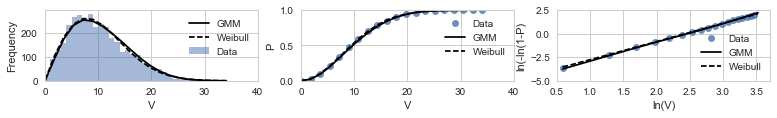

data size: 3555 weight 0.12351469668542839
GMM Weibull
R square 0.978030592268 0.982125400309
max diff: 0.033778970616 0.0148175351144 speed value: 8.96842105263 y gmm 0.448640157373
 
305.0 (295.0 - 315.0) degree


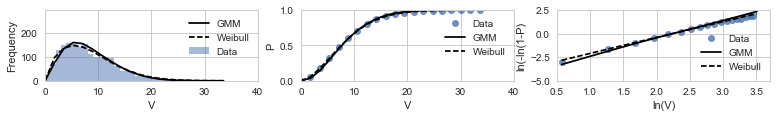

data size: 1778 weight 0.061774720311305674
GMM Weibull
R square 0.966434862311 0.975819876063
max diff: 0.0308913542296 0.0117926180358 speed value: 3.53368421053 y gmm 0.14346185162
 
325.0 (315.0 - 335.0) degree


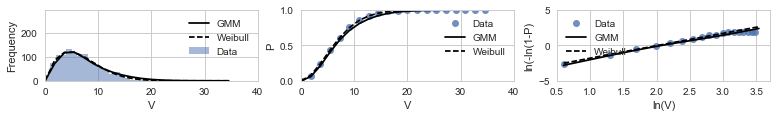

data size: 1150 weight 0.03995552776040581
GMM Weibull
R square 0.979582508842 0.988996069121
max diff: 0.0472196428738 0.0056214152616 speed value: 10.9105263158 y gmm 0.808432531039
 
345.0 (335.0 - 355.0) degree


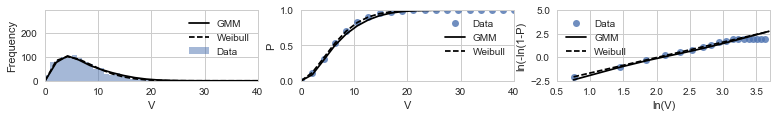

data size: 988 weight 0.03432700993676603
GMM Weibull
R square 0.97245746577 0.985633526054
max diff: 0.0515834495 0.013354398077 speed value: 8.44842105263 y gmm 0.659955012038
 
Wall time: 58.7 s


In [66]:
%%time
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 20
max_diff_array, curve_collection = model_data_comparison(df, SECTOR_LENGTH, rebinned_angle)

0.9486624454401187 0.9633202789046141


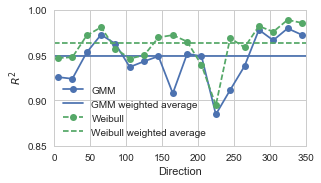

In [67]:
diff_df = pd.DataFrame(max_diff_array,columns=['datasize','direction', 'gmm', 'speed_gmm',
                                               'weibull', 'speed_weibull', 'r_square_gmm', 'r_square_weibull'])  

gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.r_square_gmm, diff_df.r_square_weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="$\ R^2$")
ylim = min(plt.gca().get_ylim()[0],0.85)
plt.gca().set_ylim(top=1, bottom=ylim)
print(gmm_mean, weibull_mean)

0.05403018760964873 0.020927600236159694


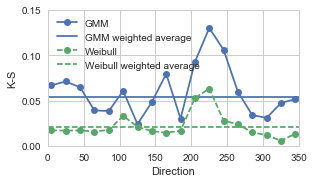

In [68]:
gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.gmm, diff_df.weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="K-S")
ylim = max(plt.gca().get_ylim()[1],0.15)
plt.gca().set_ylim(top=ylim, bottom=0)
print(gmm_mean, weibull_mean)

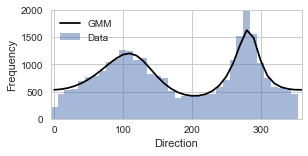

In [69]:
# Compare direction weight with previous figure
display(dir_fig)

### 5.3.1 Data Variability, by Bootstrap (Resampling)

In [70]:
max_diff_element = max(max_diff_array, key=lambda x: x[2])
angle =  max_diff_angle = max_diff_element[1]
incre = rebinned_angle

In [71]:
FRACTION = 1

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
weibull_params = sp.stats.weibull_min.fit(sub_df.speed, loc=0)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: divide by zero encountered in log


225.0 (215.0 - 235.0) Degree Speed Distribution
0.147235508944 6.0 0.551559671779


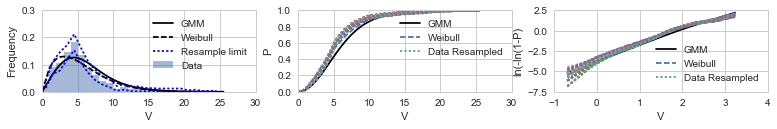

In [72]:
fig = plt.figure(figsize=(13,1.5))
ax1 = fig.add_subplot(1,3,1)   
ax2 = fig.add_subplot(1,3,2)   
ax3 = fig.add_subplot(1,3,3)   

x = arange(0, sub_max_speed, 0.5)

# 1. Data
bins=arange(0, sub_max_speed)
sub_df['speed'].hist(ax=ax1, bins=bins, alpha=0.5, label='Data', normed=True)  

# 2. GMM
y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_ in x]
direction_prob = integrate.nquad(f, [[0, inf], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(list(zip(*y_gmm_))[0])/direction_prob[0]/0.02  
y_gmm_cdf_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
y_gmm_cdf = array(list(zip(*y_gmm_cdf_))[0])/direction_prob[0]
ax1.plot(x, y_gmm,'-', color='black', label='GMM')
ax2.plot(x, y_gmm_cdf,'-', color = 'black', label='GMM')
ax3.plot(log(x), log(-log(1-y_gmm_cdf)),'-', color = 'black',label='GMM')

# 3. Weilbull 
y_weibull = sp.stats.weibull_min.pdf(x, *weibull_params)
y_weibull_cdf = sp.stats.weibull_min.cdf(x, *weibull_params)
ax1.plot(x, y_weibull,'--',color='black',label='Weibull')
ax2.plot(x, y_weibull_cdf,'--',label='Weibull')
ax3.plot(log(x), log(-log(1-y_weibull_cdf)),'--',label='Weibull')

# 4. Data Resampled
count_collection = []
for i in range(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)    
    resampled_count, _ = np.histogram(sub_df_resampled['speed'], bins=bins, normed=True) 
    count_collection.append(resampled_count)
    
    ecdf = sm.distributions.ECDF(sub_df_resampled.speed)
    y_ecdf = ecdf(x) 
    ax2.plot(x, y_ecdf,':', label='Data Resampled')
    ax3.plot(log(x), log(-log(1-y_ecdf)),':', label='Data Resampled')
    if i == 1: 
        plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
        plt_configure(ax=ax3, xlabel='V',ylabel='ln(-ln(1-P)',legend={'loc':'best'})

print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
count_collection = np.array(count_collection)
mx, mn = np.max(count_collection,0), np.min(count_collection,0)
ax1.plot(bins[1:]-0.5, mx, ':', color='blue')
ax1.plot(bins[1:]-0.5, mn, ':', color='blue', label='Resample limit')
ax1.set_ylim(bottom = 0)
plt_configure(ax=ax1, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.locator_params(axis='y', nbins=5)
ax2.locator_params(axis='y', nbins=5)
ax3.locator_params(axis='y', nbins=5)

diff = abs(y_ecdf - y_gmm_cdf)
print(diff.max(), x[diff.argmax()], y_gmm_cdf[diff.argmax()])

### 5.3.2 Time Variability

In [73]:
fig_time_variability_3d = plt.figure()
ax1 = fig_time_variability_3d.gca(projection='3d')

fig_time_variability_cdf,ax2 = plt.subplots(figsize=(3,1.8))
fig_time_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))
 
x = arange(0, sub_max_speed, 0.5)

# 1. GMM
direction_prob = integrate.nquad(f, [[0, inf], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_ in x]
y_gmm = array(list(zip(*y_gmm_))[0])/direction_prob[0]/0.02
y_gmm_cdf_ =[integrate.nquad(f, [[0, x_val],
                         [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
y_gmm_cdf = array(list(zip(*y_gmm_cdf_))[0])/direction_prob[0]

ax2.plot(x, y_gmm_cdf,'-', color='black', label = 'GMM')
ax3.plot(log(x), log(-log(1-y_gmm_cdf)),'-', color='black',label='GMM')

# 2. Weibull
y_weibull = weibull_min.pdf(x, *weibull_params)
y_weibull_cdf = weibull_min.cdf(x, *weibull_params)
ax2.plot(x, y_weibull_cdf,'--', label='Weibull')
ax3.plot(log(x), log(-log(1-y_weibull_cdf)), '--', label='Weibull')

# 3. Data
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])
for start_time in range(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    time_label = start_time//10000
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, sub_max_speed_other_year = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        ecdf = sm.distributions.ECDF(df_other_years_at_angle.speed)
        y_ecdf = ecdf(x)
        ax2.plot(x, y_ecdf,':', label = time_label)
        ax3.plot(log(x), log(-log(1-y_ecdf)),':', label = time_label)
        
        title = '%s - %s' %(time_label, time_label+4)
        count, division = np.histogram(df_other_years_at_angle['speed'], normed=True,
                                       bins=arange(0, sub_max_speed_other_year))
        ax1.bar(left=division[:-1], height=count, zs=time_label, zdir='x', 
                color=next(prop_cycle), alpha=0.8)
        x_3d = time_label*np.ones_like(x)
        ax1.plot(x_3d, x, y_gmm, '-', color='black', label='GMM'  if time_label == 2010 else '')
        ax1.plot(x_3d, x, y_weibull, '--', color='blue', label='Weibull' if time_label == 2010 else '')
        
print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
ax1.set_ylim(bottom = 0)
ax1.set_zlabel('Frequency')
plt_configure(ax=ax1, xlabel='Time',ylabel='V', legend=True)
plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
ax1.set_zlim(bottom = 0)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: divide by zero encountered in log


225.0 (215.0 - 235.0) Degree Speed Distribution


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcwAAAE5CAYAAAAdhBAsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXuYHGWZ9/+tPs5Mz6Hn0DOZc2aSQEjCAAaJEc2LhkiM
cqlo0KCoBAFZdjXLu24wL+EgSlyyIl4uYV1ZBfGAwg9WWAkuhKMRWUA5JJAwmUwmmSTTx+mePldX
df3+GJ7K0zVV3VXV1TPd0/W5Li+ZyXR1dXX38637fu77ezOCIAgwMTExMTExyYtlrk/AxMTExMSk
EjAF08TExMTERAWmYJqYmJiYmKjAFEwTExMTExMVmIJpYmJiYmKiAlMwTUxMTExMVGAKpomJiYmJ
iQpMwTQxMTExMVGBKZgmJiYmJiYqMAXTxMTExMREBaZgmpiYmJiYqMAUTBMTExMTExWYgmliYmJi
YqICUzBNTExMTExUYAqmiYmJiYmJCkzBNDExMTGZNY4dO4ZvfOMbuPTSS/HlL38ZV199NYaHh/Hj
H/8YZ5xxBrxer/i3wWAQy5cvxyOPPILx8XGcfvrp+I//+I+c433961/H5ZdfPivnbgqmiYmJicms
kEwmce211+KKK67A7373O/ziF7/A3//93+M73/kOAGDhwoXYvXu3+PdPPPEEOjs7xZ/7+vrwxz/+
Ufx5cnISY2Njs3b+tll7JhMTExOTsuFb3/oWHnroIUOPuXHjRuzcuVPx35999ll84AMfwDnnnCP+
bmhoCL/4xS/wb//2b9iwYQOefPJJfPWrXxX//iMf+Yj4t83NzXC73RgZGcGiRYuwe/durF+/Hq++
+qqhr0MJM8I0MTExMZkVxsfH0dfXJ/587bXX4vLLL8f69esxMTGBtrY21NbW4tixYxgbG8OCBQvg
dDpzjvGJT3wCf/jDHwAAe/bswYUXXjhr529GmCYmJiZVyM6dO/NGg6VgwYIF2Ldvn/jzPffcAwC4
9NJLwfM8gFOCyHEcLr74YuzduzfnGBdeeCG++MUv4pJLLoHH40FNTc2snb8ZYZqYmJiYzApr167F
Sy+9hNdff1383djYGCYmJsAwDADgoosuwp49e/Dqq69i1apVM47hcrkwMDCAnTt34pOf/OSsnTtg
CqaJiYmJySzhcrlwzz334P7778eXvvQlfOELX8C2bdvw7W9/G11dXQCAhoYGLFiwAMuWLYPFIi9R
F198MV577TWsXr16Nk8fjCAIwqw+o4mJiYmJSQViRpgmJiYmJiYqMAXTxMTExMREBWaVrElVks1m
wXEcWJaF1WqFxWKB1WqF1WoViw9MTExMaEzBNKkqstksvF4vmpubxZ8FQYAgCIjH44hGo+jq6oLF
YgHDMKaQmpiYiJiCaVIVZLNZ8DyPbDaLkydPwu12I5vNIpPJwG63i2JIBJT0hJGaOIZhRAE1hdTE
pDoxBdNkXkNSr3QxuCAI8Pv9CIVCYBgGPM/D4XDAYrGA4zjE43E4HA7YbLYcMVQrpDabTfzZxMRk
/mAW/ZjMS3ieB8uyYFlWFDeO48RJCCzLYmBgAAMDAxgcHER7ezucTicEQcDk5CSOHj2KkZERHD16
FBMTE5icnEQ8HhfFlwglcEpIOY5DOp0WU7uxWAyJRALJZBLpdBo8z8Ps4jKpZr7yla/gzTffBDD9
HVy5ciXuvfde8d8vv/xyvPPOOzMe98ILL+C3v/0txsfHcemll6p+vvPPP1887sjISJFnb0aYJvMM
nufF1CsRNY7jEAgEMDk5icbGRlgsFnR2dsJqtYpFP7W1tRAEAel0Gj09PeKx0uk0WJZFOp1GLBYT
BdjpdMLhcMDhcIj/XSgiTafTAACLxSJGoCSta0akJtXA+eefj1dffRVDQ0N47bXX8KEPfQjPP/88
vva1ryGdTuP48eNYunTpjMetWbMGwLQX7VxiCqbJvEBOKDOZDAKBAMLhMJqamrBo0SI4HA5Eo9Gc
lKoSVqsVdXV1qKury/k9qa4lYhqLxZBOp8EwTI6Akv+W7nPSQprJZMSIleyL0v9tCqlJKVm4cObv
Nm0CduzQ9+9HjuR/vg9+8IPYtWsXNm/ejOeffx4bN27Ev/7rvyIajWL//v0477zz8Morr+CHP/wh
rFYrent78Z3vfAePP/44Dh8+jC984QsIhUL4+te/jmAwiAsuuADXXXcdbrjhBmzYsAFr1qzBCy+8
gCeeeALf//73tV0MFZiCaVLRyAkly7IIBAKIRCJwu91YvHgx7HZ7wWMxDKMqZWqz2WCz2XKElIgg
EdFUKoWpqSmwLAuGYUQRpcWUiCOd2uU4TvxvIqS0cPI8LyvCJiaVwLJly3D48GEIgoBXXnkF119/
PVavXo0///nPOHjwID70oQ9h+/bt+PWvf43W1lbcddddePTRR2GznZKqRCKBnTt3oq6uDl/84hex
du3aWTt/UzBNKg5BEHKqXmmh9Pv9mJqaQnNzM5YsWZLzRSOoFUYtMAwjCqnL5co5V7K3ybIskskk
wuGwmAqmRZT8PxFHunI3m80CAA4dOoSFCxeKhUXSYiP6cSYmhSgUERb771IsFguWLl2KF154AR6P
Bw6HA2vWrMFzzz2HAwcO4Itf/CK2b9+OLVu2AABSqRQ++MEPor+/XzzG0qVL0dDQAAA488wzMTo6
mvMcpawTMAXTpGJQEsp0Og2/349oNIqWlhZFoSQoCWaphNRut8+IcAVBQCaTEQuTEomEKKQ2m23G
/igRUnJMIFdI6RSz0h6piUk5cP755+MnP/kJPvGJTwAAVq5ciV27dgGYHhC9YMEC7Nq1Cw0NDdiz
Zw/q6upw8uRJ8fEjIyOIx+NwOp1488038fnPfx4vvfQS/H4/AODtt98u2bmbgmlS9hChlFaoptNp
+Hw+xGIxVUIpZS4jMbLf6XA4cn5PhJTeH2VZFplMBjabDdlsFqFQCDU1NeLjpVElLaQsy4rPJxVS
aZGSicls8MEPfhA33ngj7rjjDgCAw+FAQ0MDzjjjDFgsFvy///f/cPXVV0MQBLhcLtxxxx05gtnU
1IR//Md/RCgUwoYNG7B48WJs3LgR27Ztw+OPP46FchuvBmFOKzEpWwRBQDKZRCQSQXNzs7i4p1Ip
+P1+xGIxtLa2orW1FVarVfVxh4eH0dvbi5qaGlFQACCdTuPkyZMl/cLpRRAEsCyLo0ePwu12i6LK
cRzsdvuM1C5txqB0PGCmkNpsNnN/1MREATPCNCk7SAENz/NIpVKYnJxES0sLkskk/H4/EokEWltb
0dXVpUkoCaVIvZYaUjjEMAxaWlrE103cikhESgqNiJBK90eJkGqJSE1XIxOTaUzBNCkbaKGkWy14
nsfY2BiSySTa2trQ09NT9J7cbO1hlhqLxQKn0wmn05nz+2w2m9P6QvZHiauRtPVFrmCICCl9TUg6
17QHNKlGTME0mXPkhJJhGCQSCUxMTIBlWbS2tqK3t9eQ4pVqWNwtFgtqampQU1OT83vaASmdTiOR
SCCdTiObzcq2vsjtc0rtAcnzkbRuJpNBTU1NwbSwiUmlYQqmyZyhJJTxeBw+nw8sy6K5uRmZTAat
ra2GPe9sVsmWG8TVqLa2Nuf3REilxUaCIMi2vuQzYzhy5Ai6urrEFLJpWG8yXzAF02TWkRNKAIjF
YvD5fOA4Dh6PRyxumZycNPT5aWGsBpFUg5KQFnI1koqp1WrNeU/NyS8m8wlTME1mDdqkHDiVGo1G
o/D5fOB5Hu3t7WhqahL/bTYFzRTPmehxNaJbX9REpEqpXXPyi0m5YQqmSckhZgNkgSTCNDU1Bb/f
j2w2i/b2djQ2Ns5YGEtlJpDNZhGNRhGJRMRqUj0Vt9VIIVejsbEx2Gw2pFIpRCIRVa5G9DFMw3qT
csUUTJOSQbv

### 5.3.3 Adjacent Sector Variability

In [74]:
incre = rebinned_angle
angle_group = [max_diff_angle-incre, max_diff_angle, max_diff_angle+incre]

In [75]:
fig_adjecent_variability_3d = plt.figure()
ax1 = fig_adjecent_variability_3d.gca(projection='3d')
fig_adjecent_variability_cdf, ax2 = plt.subplots(figsize=(3,1.8))
fig_adjecent_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

legend_3d = False
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])

curve_df = pd.DataFrame(curve_collection)

for angle in angle_group:
    curves = curve_df.query('angle == @angle%360').T.to_dict()
    curves = curves[list(curves)[0]]
    data_size, x =  curves['data_size'], curves['x']
    y_gmm, y_cdf_gmm =  curves['gmm_pdf'], curves['gmm_cdf'] 
    y_weibull, y_cdf_weibull, y_cdf = curves['weibull_pdf'],  curves['weibull_cdf'], curves['ecdf']

    linestyle = '-' if angle == max_diff_angle else ':'
    alpha = 0.7 if angle == max_diff_angle else 0.3

    ax2.plot(x, y_gmm*data_size, linestyle, label=angle)        
    ax3.plot(x, y_weibull*data_size, linestyle, label=angle)

    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

    x_3d = angle*np.ones_like(x)
    ax1.plot(x_3d, x, y_gmm*data_size, color='black', label='GMM')
    ax1.plot(x_3d, x, y_weibull*data_size, color='blue', linestyle='--',label='Weibull')

    count, division = np.histogram(sub_df['speed'], bins=arange(0, sub_max_speed))
    ax1.bar(left=division[:-1], height=count, zs=angle, zdir='x', color=next(prop_cycle), alpha=0.8)

    if legend_3d == False:
        ax1.legend()
        legend_3d = True
        
plt_configure(ax=ax1, xlabel='Direction', ylabel='Speed')   
plt_configure(ax=ax2, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.set_zlabel('Frequency')
ax1.set_zlim(bottom = 0)
ylim = max(ax1.get_ylim()[1],ax3.get_ylim()[1])
ax2.set_ylim(bottom = 0, top=ylim)
ax3.set_ylim(bottom = 0, top=ylim)

print(max_diff_angle) 
print('GMM, Weibull, Histogram')
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


225.0
GMM, Weibull, Histogram


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcwAAAE5CAYAAAAdhBAsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXucHFWdPvxU9W16eu6XnmsmmSQDIQkjMUAS4mZlgY2L
siiSrESCchN5EQy+XgDloqAuBAE/aBBBdA2uIayCqIC/n5HbAq+CUZCQkGRuySQzfZ+evld3Vb1/
DKdyuqaqu7q7uqZnpp7PJ5/MdE+fc6q66jz1vT1fRhRFESZMmDBhwoSJnGBnegEmTJgwYcLEbIBJ
mCZMmDBhwoQGmIRpwoQJEyZMaIBJmCZMmDBhwoQGmIRpwoQJEyZMaIBJmCZMmDBhwoQGmIRpwoQJ
EyZMaIBJmCZMmDBhwoQGmIRpwoQJEyZMaIBJmCZMmDBhwoQGmIRpwoQJEyZMaIBJmCZMmDBhwoQG
mIRpwoQJEyZMaIBJmCZMmDBhwoQGmIRpwoQJEyZMaIBJmCZMmDBhwjAcPXoUN9xwAzZv3ozLLrsM
n/vc53Do0CE8+OCDOOWUU+DxeKS/DQQCWLFiBX79619jdHQUJ598Mn784x9njff5z38eW7duNWTt
JmGaMGHChAlDkEgkcO211+Lyyy/H7t278fOf/xxf+MIX8K1vfQsAsGjRIjz33HPS3z/77LPo6OiQ
fu/p6cEf/vAH6fdQKISRkRHD1m81bCYTJkyYMFEx+MpXvoInn3xS1zE3bdqE7du3q77/wgsvYO3a
tVi1apX0Wn9/P37+85/jBz/4Ac4//3w8//zz+OxnPyv9/dlnny39bWNjIxoaGjAwMIAlS5bgueee
w0c+8hG8+eabuh6HGkwL04QJEyZMGILR0VH09PRIv1977bXYunUrPvKRj2B8fBwtLS1wOp04evQo
RkZG0N7eDofDkTXGRz/6Ufz+978HAOzZswfnnnuuYes3LUwTJkyYmIfYvn17TmuwHGhvb8c777wj
/f7QQw8BADZv3gye5wGcIMRMJoMLLrgAr776atYY5557Lj796U/joosuQmtrK6qqqgxbv2lhmjBh
woQJQ3DOOefg9ddfx9///nfptZGREYyPj4NhGADAxo0bsWfPHrz55ptYs2bNtDFcLhd6e3uxfft2
fOxjHzNs7YBJmCZMmDBhwiC4XC489NBD+K//+i9ceuml+NSnPoVbbrkFN998Mzo7OwEAtbW1aG9v
x/Lly8GyyhR1wQUX4K9//SvWrVtn5PLBiKIoGjqjCRMmTJgwMQthWpgmTJgwYcKEBpiEacKECRMm
TGiAmSVrYl5CEARkMhlwHAeLxQKWZWGxWGCxWKTkAxMmTJigYRKmiXkFQRDg8XjQ2Ngo/S6KIkRR
RCwWQyQSQWdnJ1iWBcMwJpGaMGFCgkmYJuYFBEEAz/MQBAFjY2NoaGiAIAhIp9Ow2WwSGRICJTVh
JCeOYRiJQE0iNWFifsIkTBNzGsT1SieDi6IIn8+HYDAIhmHA8zzsdjtYlkUmk0EsFoPdbofVas0i
Q61EarVapd9NmDAxd2Am/ZiYk+B5HhzHgeM4idwymYzUCYHjOPT29qK3txeLFy+G2+2Gw+GAKIoI
hUI4cuQIBgYGcOTIEYyPjyMUCiEWi0nkS4gSOEGkmUwGqVRKcu1Go1HE43EkEgmkUinwPA+zisvE
fMZnPvMZvP322wCm7sHVq1fj0Ucfld7funUr9u/fP+1zL7/8Mp544gmMjo5i8+bNmudbv369NO7A
wECJqzctTBNzDDzPS65XQmqZTAZ+vx+hUAh1dXVgWRYdHR2wWCxS0o/T6YQoikilUuju7pbGSqVS
4DgOqVQK0WhUImCHwwG73Q673S79nM8iTaVSyGQyCIVC6OjoAMMwklvXtEhNzAesX78eb775Jvr7
+/HXv/4VH/rQh/DSSy/hqquuQiqVwrFjx7Bs2bJpn9uwYQOAKS3amYRJmCbmBJSIMp1Ow+/3Y2Ji
AvX19ViyZAnsdjsikUiWS1UNFosF1dXVqK6uznqdZNcSMo1Go0ilUmAYJotAyc90nJMkFxEiTafT
ksVK4qL0zyaRmignFi2a/tollwDf/W5x7w8P557vrLPOwo4dO3DFFVfgpZdewqZNm3DvvfciEolg
3759OPPMM/HGG2/g/vvvh8ViwYIFC/Ctb30Lv/3tbzE4OIhPfepTCAaD+PznP49AIIAPf/jDuO66
63DTTTfh/PPPx4YNG/Dyyy/j2WefxX/+538WdjI0wCRME7MaSkTJcRz8fj/C4TAaGhqwdOlS2Gy2
vGMxDKPJZWq1WmG1WrOIlFiThESTySQmJyfBcRwYhpFI1GKxSAlIhBxpMs1kMtLPhEhp4jSJ1MRs
xvLlyzE4OAhRFPHGG2/gS1/6EtatW4fXXnsN7733Hj70oQ/h1ltvxX//93+jubkZDzzwAJ566ilY
rSeoKh6PY/v27aiursanP/1pnHPOOYat3yRME7MOoihmZb3SROnz+TA5OYnGxkb09fVl3WgEWomx
EDAMIxGpy+XKWiuJbXIch0QiAUEQMDg4CIvFkmWRkv8JGdKZu4IgSOOR+ViWnZZsRH/OhIl8yGcR
lvq+HCzLYtmyZXj55ZfR2toKu92ODRs24MUXX8SBAwfw6U9/Grfeeiu2bdsGAEgmkzjrrLOwcOFC
aYxly5ahtrYWAHDqqadiaGgoa45y5gmYhGli1kCNKFOpFHw+HyKRCJqamlSJkkCNMMtFpDabTbJw
OY7DsWPHsGjRIqTTaSkxKR6PY2JiAhzHwWq1TouP0kRKkItIY7EYnE4nqqqqJIvUhIlKwPr16/Hw
ww/jox/9KABg9erV2LFjB4CpBtHt7e3YsWMHamtrsWfPHlRXV2NsbEz6/MDAAGKxGBwOB95++238
x3/8B15//XX4fD4AwLvvvlu2tZuEaaLiQYgyGAxiYmICPT09ElF6vV5Eo1FNRCnHTFhihJRJvNNu
t2e9L4oi0ul0VnyU4zik02lYrdZp1qjdbp9mVQqCgEAggMbGRlWL1GKxTEtSMmHCCJx11ln4xje+
gXvuuQcAYLfbUVtbi1NOOQUsy+LrX/86Pve5z0EURbhcLtxzzz1ZhFlfX48bb7wRwWAQ559/PpYu
XYpNmzbhlltuwW9/+1ssUgq86gSzW4mJigWJC5JyjGg0ikAggPb2dvh8PkSjUTQ3N6O5uRkWi0Xz
uIcOHcKCBQtQVVUFjuOk11OpFMbGxsp6w6XTaRw9ehSLFy8u6HOiKErWKJ25m8lkYLPZprl2PR4P
mpqastzD8vGA6URqtVpNMQYTJlRgWpgmKg5yoqRjlIlEAsPDw2hubkZnZ2dBRElQDtdruUEShxwO
hxS/ASCpFRESJYlG6XQaHo8HTqczi0yJqpGaa5c8QNBEaqoamTAxBZMwTVQM1IgyHo/D5/MhHo+D
ZVn09fWVHJMzKoZZbrAsKxEpjaNHj6KmpgYsy4LjOCk+SlSN5KUvSglDhEjpc0LcueRviWvZJFIT
8wEmYZqYceQiSq/Xi2QyidbWVjQ3N8Pj8ZRMljO9uRtFyna7fZpLllZASqVSiMfjSKVSEARBMT6q
FOckNaQ8z2NgYEB6gDF1dk3MdZiEaWLGoEaUsVgMXq8XHMehtbUVPT09YFkWiURCF7IxMktWaQ6j
oDQXUTVyOp1ZrxMilScbiaKoWPoitzJNwXoT8wEmYZowHEpECQDRaBRerxeZTAatra1oaGjI2lj1
IjR6nNnohi0H1Ig0l6qRzWaDKIqYmJhQVDUCtAvWm0RqYjbAJEwThoEWKQdOWECRSARerxc8z8Pt
dqO+vl514ywnuZnkOR25VI0SiQTGx8dVVY2ULFL5GORnAiUxBlPVyESlwCRME2UHz/MIhUKoqakB
cIKYJicn4fP

# 6. Result Variability & Cross-Validation

In [76]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
if 'FIT_METHOD' not in globals():
    FIT_METHOD = 'square_error'       
if 'KDE_KERNEL' not in globals():
    KDE_KERNEL = 'gaussian'
    
config = {'bandwidth': bandwidth, 
          'fitting_range': FITTING_RANGE,
          'fit_limit': fit_limit,
          'kde_kernel': KDE_KERNEL}

## 6.1 Variability of the Result

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.544  -1.162   4.181  7.176  7.427  -0.218
2  0.244   2.479  -5.528  3.362  9.629  -0.163
3  0.212  -0.384  -3.195  2.796  4.826  -0.095

GMM Plot Result
0.543776848335 [[-1.16223518  4.18147839]] [ 6.44698708  8.06800291] -139.495405055
0.244074960581 [[ 2.47899217 -5.52755728]] [ 3.3110008   9.64629682] -176.309884935
0.212148191084 [[-0.38379286 -3.19513411]] [ 2.776955    4.83677603] -175.273538187


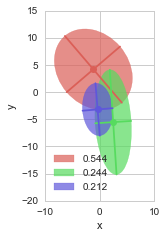

R_square       K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.004285      0.010  2.483248e-09      0.011       0.078

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.006      0.009  2.468048e-09      0.011       0.078

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.612  -0.534   4.003  7.088  7.829  -0.213
2  0.203   1.213  -7.176  3.402  6.813  -0.450
3  0.185   0.550  -1.919  3.081  4.872   0.124

GMM Plot Result
0.612422729563 [[-0.53395999  4.00311422]] [ 6.53632957  8.29480949] -147.547677091
0.202500805866 [[ 1.21292619 -7.1763218 ]] [ 2.94704643  7.02195778] -164.532230638
0.185076464572 [[ 0.54993463 -1.91909158]] [ 3.04248335  4.89594138] 172.699147712


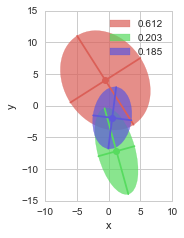

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.996  0.008      0.012  2.900509e-09      0.012       0.085

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.996  0.008      0.011  2.906788e-09      0.012       0.085

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.599  -0.709   3.967  7.153  8.035  -0.228
2  0.201   1.210  -7.512  3.437  6.253  -0.444
3  0.200   0.617  -0.910  3.071  4.888   0.172

GMM Plot Result
0.598740804898 [[-0.70852589  3.96737927]] [ 6.56912179  8.51927485] -148.551634483
0.201012013075 [[ 1.2099548  -7.51170613]] [ 2.96827349  6.48833023] -162.524858196
0.200247182027 [[ 0.6172743 -0.910121 ]] [ 2.99758865  4.93341288] 170.161397033


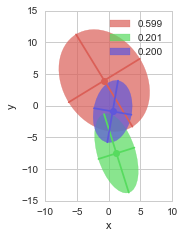

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.006      0.009  2.565014e-09      0.011       0.079

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.006      0.010  2.794524e-09      0.012       0.083

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.568  -0.958   3.900  7.121  7.450  -0.204
2  0.246   2.248  -5.542  3.260  8.852  -0.164
3  0.187  -0.442  -3.241  2.730  4.661  -0.081

GMM Plot Result
0.567564547897 [[-0.95843628  3.89993253]] [ 6.4804957   8.01283601] -141.238635904
0.245602662723 [[ 2.24848053 -5.54176385]] [ 3.20980483  8.87032571] -176.031712975
0.18683278938 [[-0.44158341 -3.24059408]] [ 2.71639829  4.66895276] -175.86535442


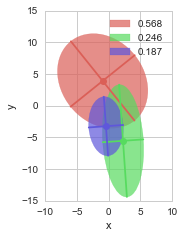

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.005      0.009  2.172003e-09      0.010       0.073

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.010      0.009  2.519036e-09      0.011       0.079

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.584  -0.687   4.175  7.141  7.987  -0.204
2  0.230   0.525  -1.345  3.215  5.230   0.090
3  0.186   1.191  -7.466  3.538  6.446  -0.499

GMM Plot Result
0.584339471405 [[-0.68650064  4.17454307]] [ 6.64187711  8.40669624] -149.416913865
0.229744045645 [[ 0.52464672 -1.34517545]] [ 3.19412917  5.24231248] 174.984002874
0.18591648295 [[ 1.19050368 -7.46631616]] [ 2.92993159  6.74395297] -160.949680557


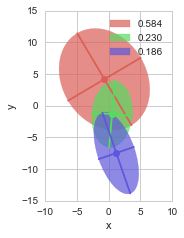

R_square       K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.996  0.004915      0.011  2.991870e-09      0.012       0.086

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.007      0.011  2.803015e-09      0.012       0.083

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.602  -0.642   3.901  7.071  7.977  -0.226
2  0.265   0.983  -5.801  3.305  6.802  -0.397
3  0.133   0.635  -0.948  3.188  4.653   0.343

GMM Plot Result
0.602373672011 [[-0.64227911  3.90097383]] [ 6.50891879  8.44184635] -149.068937905
0.264776223743 [[ 0.98298916 -5.80104815]] [ 2.96537779  6.95664321] -166.592344405
0.132850104246 [[ 0.63474959 -0.94808146]] [ 2.86899807  4.85592527] 159.209276798


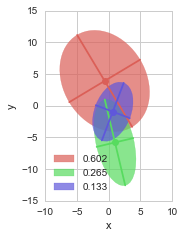

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.007      0.011  2.793808e-09      0.011       0.083

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.006      0.011  2.733255e-09      0.011       0.082

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.550  -1.095   4.096  7.389  7.583  -0.209
2  0.307   1.777  -4.043  3.225  8.433  -0.208
3  0.143  -0.757  -3.359  2.662  4.151  -0.088

GMM Plot Result
0.550064597781 [[-1.09474394  4.09604409]] [ 6.65135034  8.23804086] -138.531064312
0.307058891449 [[ 1.77726779 -4.04283711]] [ 3.14316397  8.46386238] -174.732736202
0.14287651077 [[-0.75735939 -3.35941008]] [ 2.64442799  4.1624789 ] -174.581166732


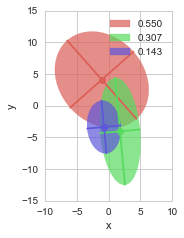

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.009      0.009  2.512864e-09      0.011       0.079

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.007      0.010  2.814440e-09      0.012       0.083

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.592  -0.639   3.964  7.114  7.834  -0.224
2  0.211   0.530  -1.370  3.161  5.001   0.125
3  0.197   1.200  -7.354  3.445  6.492  -0.453

GMM Plot Result
0.591564017613 [[-0.63910386  3.96383562]] [ 6.50913572  8.34295194] -146.63377559
0.211015344846 [[ 0.53034002 -1.37000113]] [ 3.12034129  5.02671549] 172.633000901
0.197420637542 [[ 1.20028664 -7.35372865]] [ 2.96374215  6.72535721] -163.097638554


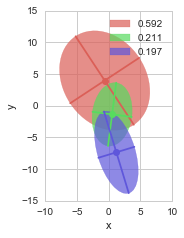

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.008      0.009  2.785959e-09      0.012       0.083

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.010      0.011  2.612067e-09      0.011       0.080

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.589  -0.752   4.203  7.062  7.649  -0.208
2  0.214   1.375  -7.179  3.491  6.649  -0.438
3  0.197   0.450  -1.546  3.144  4.969   0.172

GMM Plot Result
0.588774365158 [[-0.7518311   4.20255114]] [ 6.49123046  8.13888845] -145.495301971
0.214474094954 [[ 1.37490452 -7.17901582]] [ 3.03887179  6.86719253] -163.80388464
0.196751539888 [[ 0.44976691 -1.54631767]] [ 3.0675669   5.01597153] 170.021375399


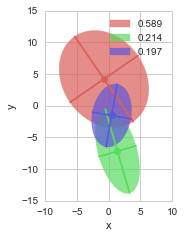

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.006      0.011  2.693365e-09      0.011       0.081

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.009      0.010  2.591510e-09      0.011       0.080

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.569  -0.847   4.309  7.307  7.750  -0.209
2  0.227   0.536  -1.235  3.219  5.118   0.108
3  0.204   1.323  -7.318  3.510  6.535  -0.445

GMM Plot Result
0.568931814742 [[-0.84698948  4.30942817]] [ 6.66522828  8.30865513] -142.867206056
0.227128124315 [[ 0.53618561 -1.23489518]] [ 3.18819111  5.13684798] 173.679830075
0.203940060943 [[ 1.32296004 -7.31816572]] [ 3.03440078  6.76928968] -163.043788827


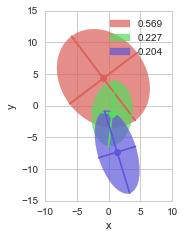

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.005      0.011  2.587952e-09      0.011       0.080

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.007      0.010  2.622763e-09      0.011       0.080


Wall time: 36.7 s


In [ ]:
%%time
results = Parallel(n_jobs=-1)(delayed(resampled_fitting)(df, FIT_METHOD, NUMBER_OF_GAUSSIAN, config) for i in range(10))                        
for result in results:
    display(pretty_print_gmm(result['gmm']))
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    plot_gmm_ellipses(result['gmm'],ax=ax)
    plt.show()
    
    display(gof_df(result['gmm_pdf_result'], result['kde_result']))
    display(gof_df(result['gmm_pdf_result'], kde_result))
    print('')

## 6.2 Cross-validation, to select the number of Gaussian

In [ ]:
%%time
from sklearn.cross_validation import train_test_split, KFold

## 5-fold cross validation
gaussian_number_range = arange(1,6)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print('Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold) 

for number_of_gaussian in gaussian_number_range:
    print( '  ')
    print('Number of gaussian', number_of_gaussian)
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result = Parallel(n_jobs=-1)(delayed(fit_per_fold)(df, train_index, test_index, FIT_METHOD, number_of_gaussian, config) for train_index, test_index in kf)                        

    CV_result_train, CV_result_test = list(zip(*CV_result))
    CV_result_train, CV_result_test = list(CV_result_train), list(CV_result_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)
    
    print('Train')
    pretty_pd_display(CV_result_train)
    print('Test')
    pretty_pd_display(CV_result_test)

Number of train/test dataset 21586.5 7195.5
  
Number of gaussian 1
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.098131  0.058086  6.616419e-08    0.055740     0.403666  0.920029
1    0.095135  0.056361  6.380679e-08    0.054577     0.396398  0.922600
2    0.098341  0.057474  6.250664e-08    0.055743     0.392710  0.923124
3    0.092888  0.056669  6.218488e-08    0.055044     0.391010  0.924123

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.099060  0.058279  6.016342e-08    0.055564     0.384943  0.925110
1    0.102237  0.064366  6.488004e-08    0.058240     0.399783  0.920182
2    0.088637  0.057110  7.196666e-08    0.055852     0.419859  0.915072
3    0.123651  0.049023  6.503851e-08    0.053971     0.401248  0.921388

  
Number of gaussian 2
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.022856  0.011718  6.536970e-09    0.017709     0.126861  0.992031
1    0.020247  0.010474  6.071216e-09    0.017263     0.122274  0.992526
2    0.022817  0.011366  6.284564e-09    0.017369     0.124391  0.992363
3    0.023491  0.011726  6.194188e-09    0.017054     0.123557  0.992524

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.027248  0.012100  6.581172e-09    0.017783     0.127377  0.992012
1    0.030379  0.015176  9.759583e-09    0.020942     0.155056  0.988509
2    0.023821  0.013379  7.417414e-09    0.018862     0.135218  0.990912
3    0.025082  0.014428  8.385954e-09    0.020749     0.143554  0.989515

  
Number of gaussian 3
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.010140  0.006750  2.488798e-09    0.010789     0.078278  0.996997
1    0.024951  0.010007  4.733435e-09    0.015104     0.107980  0.994208
2    0.010907  0.006560  2.431735e-09    0.010885     0.077356  0.997016
3    0.009744  0.007935  2.488578e-09    0.010967     0.078325  0.996978

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.013245  0.013475  3.981446e-09    0.014386     0.099070  0.995014
1    0.036734  0.013521  8.158769e-09    0.019455     0.141713  0.990225
2    0.013916  0.012610  5.297014e-09    0.015595     0.114359  0.993703
3    0.022656  0.011914  5.622539e-09    0.016258     0.117504  0.993111

  
Number of gaussian 4
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.071353  0.004512  1.809762e-09    0.009300     0.066727  0.997805
1    0.007767  0.003536  1.837808e-09    0.009276     0.067250  0.997775
2    0.007509  0.003677  1.431238e-09    0.008215     0.059399  0.998269
3    0.007760  0.004513  1.411739e-09    0.008429     0.058990  0.998251

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.033837  0.008603  4.260016e-09    0.014390     0.102587  0.994755
1    0.023234  0.008241  5.042434e-09    0.016014     0.111571  0.993762
2    0.013014  0.011859  4.854818e-09    0.015681     0.109188  0.993972
3    0.010565  0.014122  4.778543e-09    0.014150     0.108344  0.994475

  
Number of gaussian 5


In [ ]:
train_scores_mean, train_scores_std = generate_mean_std_gof(CV_result_train_all)
print('Train gof mean, std')
display(train_scores_mean)

test_scores_mean, test_scores_std = generate_mean_std_gof(CV_result_test_all)
print('Test gof mean, std')
display(test_scores_mean)

In [ ]:
prop_cycle=mpl.rcParams['axes.color_cycle']
gaussian_number_range = train_scores_mean.index
for column, column_name in zip(['R_square','K_S','Chi_square'],["$\ R^2$", "K-S", "$\widetilde{\chi^2} $"]):
    plot(gaussian_number_range, train_scores_mean[column],
             '--', label = 'train', color=prop_cycle[0])
    plt.fill_between(gaussian_number_range, 
                     train_scores_mean[column] - train_scores_std[column],
                     train_scores_mean[column] + train_scores_std[column], 
                     alpha=0.2, color=prop_cycle[0])
    
    plot(gaussian_number_range, test_scores_mean[column],
             '-', label = 'test',color=prop_cycle[1])
    plt.fill_between(gaussian_number_range, 
                 test_scores_mean[column] - test_scores_std[column],
                 test_scores_mean[column] + test_scores_std[column], 
                 alpha=0.2,color=prop_cycle[1])
    plt.xticks(gaussian_number_range)
    print(column)
    plt.locator_params(axis='y', nbins=5)
    plt_configure(xlabel='Number of Gaussian Distribution', ylabel=column_name, 
                  figsize=(3,2), legend={'loc':'best'})
    if column == 'R_square':
        plt.gca().set_ylim(top=1)
    if column == 'K_S' or column == 'Chi_square':
        plt.gca().set_ylim(bottom=0)
    plt.show()

In [ ]:
for fig in [fig_hist, fig_kde, fig_em, fig_gmm]:
    display(fig)
for fig in [fig_time_variability_3d, fig_time_variability_cdf, fig_time_variability_weibull, 
            fig_adjecent_variability_3d, fig_adjecent_variability_cdf, fig_adjecent_variability_weibull,]:
    display(fig)

In [ ]:
import time
save_notebook()
time.sleep(3)
location_name = get_location_name(file_path)
current_file = 'GMM.ipynb'
output_file = './output_HTML/'+location_name+'.html' 
output_HTML(current_file, output_file)